### Import packages

In [507]:
import warnings
warnings.filterwarnings('ignore')

import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from landlab.components import OverlandFlow, FlowAccumulator, SpatialPrecipitationDistribution, FlowDirectorSteepest, NetworkSedimentTransporter
from landlab.data_record import DataRecord
from landlab.grid.network import NetworkModelGrid
from landlab.plot import graph
from landlab.io import read_shapefile
from landlab import ExampleData
from landlab.plot.imshow import imshow_grid, imshow_grid_at_node
from landlab.io.esri_ascii import read_esri_ascii

from landlab.plot import plot_network_and_parcels
%matplotlib inline

import matplotlib.colors as mcolors
colors = [(0,0.2,1,i) for i in np.linspace(0,1,3)]
cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors, N=10)

import os
from landlab.io.esri_ascii import write_esri_ascii
import shutil

### Parameters of the model

In [508]:
# Initial conditions
run_time =5000 # 1 day 259200  # duration of run, (s) equivalent of 3 days
n = 0.01  # roughness coefficient, (s/m^(1/3))
g = 9.8  # gravity (m/s^2)
alpha = 0.7  # time-step factor (nondimensional; from Bates et al., 2010)
u = 0.4  # constant velocity (m/s, de Almeida et al., 2012)
elapsed_time = 1.0 #Elapsed time starts at 1 second. This prevents errors when setting our boundary conditions.
h_init = 0.1 # initial thin layer of water (m)

# time scale for rainfall events. To be adjusted. I am cheating with units... 
nb_years = 100
# Factor to scale rainfall values from the module SpatialPrecipitationDistribution (may generate very
# small amounts of rainfall, which renders poorly...)
rainfall_scaling = 100000.

# Folder for runoff results 
dir_runoff = './runoff_results'
# Folder for rainfall data
dir_rainfall = './rainfall_series'
# Folder for rainfall data
dir_sediments = './sedrouting_results'

# Overwrite or create directory for runoff data
if os.path.exists(dir_runoff):
    shutil.rmtree(dir_runoff)
os.makedirs(dir_runoff)

# Overwrite or create directory for rainfall data
if os.path.exists(dir_rainfall):
    shutil.rmtree(dir_rainfall)
os.makedirs(dir_rainfall)

# Overwrite or create directory for sediment routing data
if os.path.exists(dir_sediments):
    shutil.rmtree(dir_sediments)
os.makedirs(dir_sediments)


### Setup drainage network

Load shapefile of the drainage network

In [509]:
shp_file = '../data/hugo_links.shp'
# points_shapefile = '../hugo_nodes_nodublicates.shp'

grid = read_shapefile(
    shp_file,
    threshold=0.1,
    )

Plot the Network

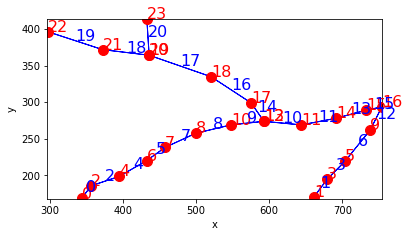

In [510]:
graph.plot_graph(grid, at="node,link")

#### Make a new grid that doesn't have duplicated nodes
* Nodes we don't want: 19, 13
* reassing all nodes_at_link that refensece the nodes we don't want 19-> 20, 12->13

In [511]:
#Drop double nodes
drop_nodes = [19,13]
new_y_of_node =[]
new_x_of_node =[]
#Find the new x and y coordinates
for i, node in enumerate(grid.y_of_node):
    if i not in drop_nodes:
        new_y_of_node.append(node)

for i, node in enumerate(grid.x_of_node):
    if i not in drop_nodes:
        new_x_of_node.append(node)

#rediect all nodes
replace_nodes = [20,12]
nodes_reformatted=np.ravel(grid.nodes_at_link)

for node, replacement in zip(drop_nodes,replace_nodes):
    nodes_reformatted[np.where(nodes_reformatted==node)]=replacement

#change index number     
for node in drop_nodes:
    nodes_reformatted[np.where(nodes_reformatted >node)] -=1
    
new_nodes_at_link=nodes_reformatted.reshape([21,2])

# Make a new network model grid
new_grid = NetworkModelGrid((new_y_of_node, new_x_of_node), new_nodes_at_link)

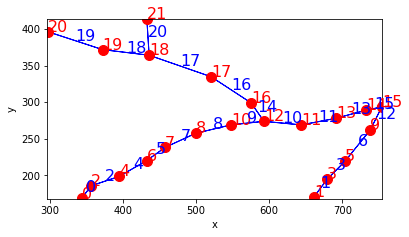

In [512]:
graph.plot_graph(new_grid, at="node,link")

### Setup the overland flow

In [513]:
#Define grid
# here we use an arbitrary, very small, "real" catchment
fname = '../data/hugo_site.asc'
rmg, z = read_esri_ascii(fname, name='topographic__elevation')
rmg.status_at_node[rmg.nodes_at_right_edge] = rmg.BC_NODE_IS_FIXED_VALUE
rmg.status_at_node[np.isclose(z, -9999.)] = rmg.BC_NODE_IS_CLOSED

#### Generate the rainfall time series

In [514]:
# Important note: SpatialPrecipitationDistribution generate rainfall events per years over
# an input grid. I guess the number of events also depends on the size of the catchment/grid
# So we need to set a nb_years as input for number_of_years. And scale the storm events over run_time.
# Let's consider rainfall instantaneous.

# Create time series of rainfall events (output is in mm/h)
rain = SpatialPrecipitationDistribution(rmg,number_of_years = nb_years)
np.random.seed(26)  # arbitrary to get a cool-looking storm out every tim

# Container for rainfall duration
storm_t_all = []
interstorm_t_all = []

# get the storm simulator to provide a storm
# Variables required to generate rainfall datasets
i = 0
max_rainfall = []
for (storm_t, interstorm_t) in rain.yield_storms():  # storm lengths in hrs
    i += 1
    rmg.at_node['rainfall__flux'] *= 0.001  # because the rainfall comes out in mm/h
    rmg.at_node['rainfall__flux'] *= rainfall_scaling  # to make the storm heavier and more interesting!

    # Save rainfall data to ascii file
    write_esri_ascii('./'+ dir_rainfall +'/rainfall_'+ str(i) + '.asc', rmg, 'rainfall__flux', clobber=True)
    
    # Save duration of storm and non-storm periods
    storm_t_all.append(storm_t)
    interstorm_t_all.append(interstorm_t)
    
    # Store max rainfall value
    max_rainfall.append(max(rmg.at_node['rainfall__flux']))

storm_ids = np.array(range(len(storm_t_all))) + 1

# Get moment of storms (initially in hours, to be rescaled over run_time 
# -> cheating to get some results...)
days_storms = (np.array(interstorm_t_all)/24)
scaled_days_storms_steps = (days_storms * (run_time / (nb_years*365))).round()
scaled_days_storms = scaled_days_storms_steps.cumsum()
# Set first storm a time = 1
scaled_days_storms = scaled_days_storms - scaled_days_storms[0] + 1
print(scaled_days_storms)

[  1.00000000e+00   3.00000000e+01   5.10000000e+01   5.10000000e+01
   8.00000000e+01   1.01000000e+02   1.30000000e+02   1.51000000e+02
   1.80000000e+02   2.01000000e+02   2.30000000e+02   2.51000000e+02
   2.80000000e+02   3.01000000e+02   3.30000000e+02   3.51000000e+02
   3.51000000e+02   3.51000000e+02   3.51000000e+02   3.80000000e+02
   4.01000000e+02   4.30000000e+02   4.51000000e+02   4.80000000e+02
   5.01000000e+02   5.30000000e+02   5.51000000e+02   5.80000000e+02
   6.01000000e+02   6.30000000e+02   6.51000000e+02   6.80000000e+02
   7.01000000e+02   7.30000000e+02   7.51000000e+02   7.80000000e+02
   8.01000000e+02   8.30000000e+02   8.51000000e+02   8.80000000e+02
   9.01000000e+02   9.30000000e+02   9.51000000e+02   9.80000000e+02
   1.00100000e+03   1.03000000e+03   1.05100000e+03   1.08000000e+03
   1.10100000e+03   1.13000000e+03   1.15100000e+03   1.15100000e+03
   1.18000000e+03   1.20100000e+03   1.20100000e+03   1.23000000e+03
   1.25100000e+03   1.28000000e+03

#### Define first rainfall on landscape

In [515]:
#Set initial water depth values and rainfall flux values
rmg.at_node["surface_water__depth"] = np.zeros(rmg.number_of_nodes)
rmg.at_node.pop('rainfall__flux')
# print(rmg.at_node.keys())

# Read first rainfall data
q_rain = read_esri_ascii('./rainfall_series/rainfall_1.asc', grid=rmg, name='rainfall__flux')
# Update id for rainfall
rainfall_id = 1

# Update surface water depth with rainfall data
rmg.at_node['surface_water__depth'].fill(1.e-12)  # a veneer of water stabilises the model
rmg.at_node['surface_water__depth'] += rmg.at_node['rainfall__flux'] # storm_t_all[0]

## Set inital discharge
rmg.at_node["surface_water__discharge"] = np.zeros(rmg.number_of_nodes)


In [516]:
# #Set up rain
# rmg.at_node["surface_water__depth"] = np.zeros(rmg.number_of_nodes)
# h = rmg.at_node['surface_water__depth']
# h+=h_init #add a little bit of water everywhere

# #ad a storm 
# bools = (rmg.node_y > 100) * (rmg.node_y < 450) * (rmg.node_x < 400) * (rmg.node_x > 200)
# h[bools] = 1 #initial water depth m

# ## Set inital discharge
# rmg.at_node["surface_water__discharge"] = np.zeros(rmg.number_of_nodes)

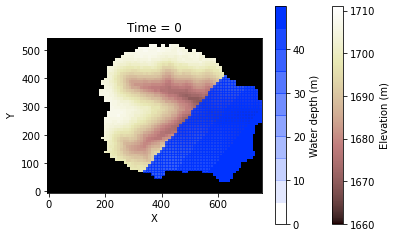

In [517]:
fig1 = plt.figure()
imshow_grid(rmg,'topographic__elevation',colorbar_label='Elevation (m)')
imshow_grid(rmg,'surface_water__depth',cmap=cmap,colorbar_label='Water depth (m)')
plt.title(f'Time = 0')
plt.show()
fig1.savefig(dir_runoff + f"/runoff_0.jpeg")# print(rmg.at_node.keys())

### Start the sediment routing part

In [518]:
nmg_node_topo = np.zeros(new_grid.number_of_nodes) #create empty array holding elevations for network model grid
nmg_node_h = np.zeros(new_grid.number_of_nodes)

for i in range(new_grid.number_of_nodes):
    idx_nearest_raster_cell = rmg.find_nearest_node([new_grid.x_of_node[i], new_grid.y_of_node[i]])
    nmg_node_topo[i] = rmg.at_node["topographic__elevation"][idx_nearest_raster_cell]

Calculate distance between links

In [519]:
nmg_link_length = np.zeros(new_grid.number_of_links)
nmg_link_h = np.zeros(new_grid.number_of_links)

for i in range(new_grid.number_of_links):
    idx_node_1_link = new_grid.nodes_at_link[i][0]
    idx_node_2_link = new_grid.nodes_at_link[i][1]
    nmg_link_length[i] = np.sqrt((new_grid.x_of_node[idx_node_2_link] - new_grid.x_of_node[idx_node_1_link])**2 
                         + (new_grid.y_of_node[idx_node_2_link] - new_grid.y_of_node[idx_node_1_link])**2)
    
    nmg_link_h[i] = rmg.at_node['surface_water__depth'][idx_node_2_link] #assume second node is downstream one

In [520]:
new_grid.at_node["topographic__elevation"] = nmg_node_topo.copy()

new_grid.at_node["bedrock__elevation"] = nmg_node_topo.copy()

new_grid.at_link["channel_width"] = 10 * np.ones(grid.number_of_links)

new_grid.at_link["flow_depth"] = nmg_link_h.copy()

new_grid.at_link["reach_length"] = nmg_link_length

### Create a sediment parcels

In [521]:
# element_id is the link on which the parcel begins. 
element_id = np.repeat(np.arange(new_grid.number_of_links), 50)
element_id = np.expand_dims(element_id, axis=1)

volume = 1*np.ones(np.shape(element_id))  # (m3)
active_layer = np.ones(np.shape(element_id)) # 1= active, 0 = inactive
density = 2650 * np.ones(np.size(element_id))  # (kg/m3)
abrasion_rate = 0 * np.ones(np.size(element_id)) # (mass loss /m)

# Lognormal GSD
medianD = 0.002 # m
mu = np.log(medianD)
sigma = np.log(2) #assume that D84 = sigma*D50
np.random.seed(0)
D = np.random.lognormal(
    mu,
    sigma,
    np.shape(element_id)
)  # (m) the diameter of grains in each parcel

We begin by assigning each parcel an arbitrary (and small) arrival time and location in the link. 

In [522]:
time_arrival_in_link = np.random.rand(np.size(element_id), 1) 
location_in_link = np.random.rand(np.size(element_id), 1) 

We now collect the arrays into a dictionary of variables, some of which will be tracked through time (`["item_id", "time"]`), and others of which will remain constant through time :

In [523]:
lithology = ["quartzite"] * np.size(element_id)

variables = {
    "abrasion_rate": (["item_id"], abrasion_rate),
    "density": (["item_id"], density),
    "lithology": (["item_id"], lithology),
    "time_arrival_in_link": (["item_id", "time"], time_arrival_in_link),
    "active_layer": (["item_id", "time"], active_layer),
    "location_in_link": (["item_id", "time"], location_in_link),
    "D": (["item_id", "time"], D),
    "volume": (["item_id", "time"], volume)
}

With all of the required attributes collected, we can create the parcels DataRecord. Often, parcels will eventually transport off of the downstream-most link. To track these parcels, we have designated a "`dummy_element`" here, which has index value `-2`. 

In [524]:
items = {"grid_element": "link", "element_id": element_id}

parcels = DataRecord(
    new_grid,
    items=items,
    time=[0.0],
    data_vars=variables,
    dummy_elements={"link": [NetworkSedimentTransporter.OUT_OF_NETWORK]},
)

### Run the NetworkSedimentTransporter

In [525]:
dt_sed = 100 # 60 * 60 * 24 *1# length of timestep (seconds) 

Before running the NST, we need to determine flow direction on the grid (upstream and downstream for each link). To do so, we initalize and run a Landlab flow director component: 

In [526]:
fd = FlowDirectorSteepest(new_grid, "topographic__elevation")
fd.run_one_step()

In [527]:
#Intialize model
#network sed transporter 
nst = NetworkSedimentTransporter(    
    new_grid,
    parcels,
    fd,
    bed_porosity=0.3,
    g=9.81,
    fluid_density=1000,
    transport_method="WilcockCrowe",
)
#overland flow 
of = OverlandFlow(rmg, steep_slopes=True)
of.run_one_step()

In [528]:
# look at hydorgraph at outlet 
hydrograph_time = []
discharge_at_outlet = []
height_at_outlet = []

#Define the outlet 
outlet_nearest_raster_cell = rmg.find_nearest_node([new_grid.x_of_node[14], new_grid.y_of_node[14]])# did not choose 15 since at boundary
outlet_link_to_sample = rmg.links_at_node[outlet_nearest_raster_cell][3]

2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
STORMMMM
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
STORMMMM
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
STORMMMM
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
Sed transporter run at model time:  0.0011574074074074073 days passed


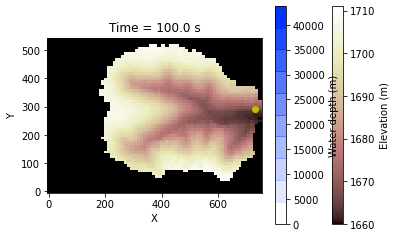

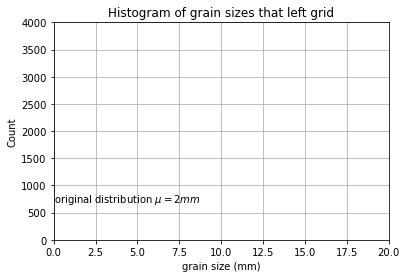

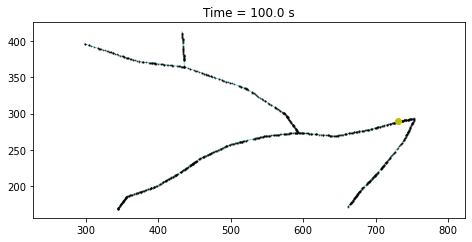

101.0
STORMMMM
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0
110.0
111.0
112.0
113.0
114.0
115.0
116.0
117.0
118.0
119.0
120.0
121.0
122.0
123.0
124.0
125.0
126.0
127.0
128.0
129.0
130.0
STORMMMM
131.0
132.0
133.0
134.0
135.0
136.0
137.0
138.0
139.0
140.0
141.0
142.0
143.0
144.0
145.0
146.0
147.0
148.0
149.0
150.0
151.0
STORMMMM
152.0
153.0
154.0
155.0
156.0
157.0
158.0
159.0
160.0
161.0
162.0
163.0
164.0
165.0
166.0
167.0
168.0
169.0
170.0
171.0
172.0
173.0
174.0
175.0
176.0
177.0
178.0
179.0
180.0
STORMMMM
181.0
182.0
183.0
184.0
185.0
186.0
187.0
188.0
189.0
190.0
191.0
192.0
193.0
194.0
195.0
196.0
197.0
198.0
199.0
200.0
Sed transporter run at model time:  0.0023148148148148147 days passed


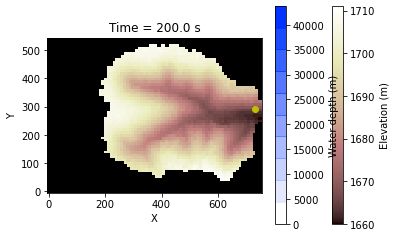

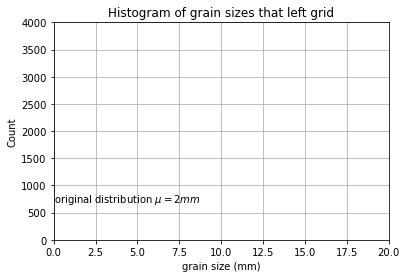

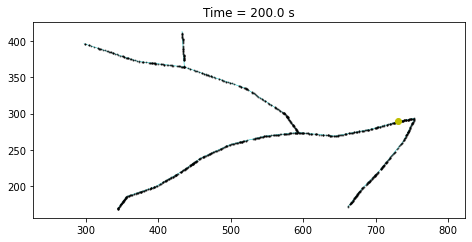

201.0
STORMMMM
202.0
203.0
204.0
205.0
206.0
207.0
208.0
209.0
210.0
211.0
212.0
213.0
214.0
215.0
216.0
217.0
218.0
219.0
220.0
221.0
222.0
223.0
224.0
225.0
226.0
227.0
228.0
229.0
230.0
STORMMMM
231.0
232.0
233.0
234.0
235.0
236.0
237.0
238.0
239.0
240.0
241.0
242.0
243.0
244.0
245.0
246.0
247.0
248.0
249.0
250.0
251.0
STORMMMM
252.0
253.0
254.0
255.0
256.0
257.0
258.0
259.0
260.0
261.0
262.0
263.0
264.0
265.0
266.0
267.0
268.0
269.0
270.0
271.0
272.0
273.0
274.0
275.0
276.0
277.0
278.0
279.0
280.0
STORMMMM
281.0
282.0
283.0
284.0
285.0
286.0
287.0
288.0
289.0
290.0
291.0
292.0
293.0
294.0
295.0
296.0
297.0
298.0
299.0
300.0
Sed transporter run at model time:  0.003472222222222222 days passed


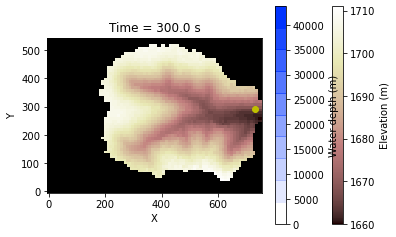

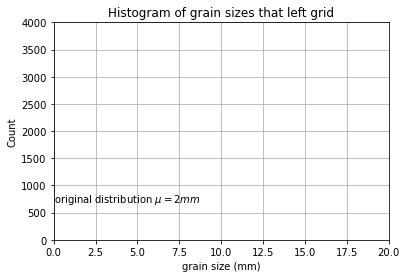

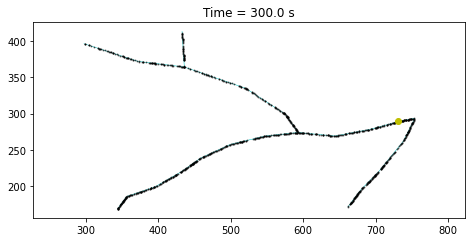

301.0
STORMMMM
302.0
303.0
304.0
305.0
306.0
307.0
308.0
309.0
310.0
311.0
312.0
313.0
314.0
315.0
316.0
317.0
318.0
319.0
320.0
321.0
322.0
323.0
324.0
325.0
326.0
327.0
328.0
329.0
330.0
STORMMMM
331.0
332.0
333.0
334.0
335.0
336.0
337.0
338.0
339.0
340.0
341.0
342.0
343.0
344.0
345.0
346.0
347.0
348.0
349.0
350.0
351.0
STORMMMM
352.0
353.0
354.0
355.0
356.0
357.0
358.0
359.0
360.0
361.0
362.0
363.0
364.0
365.0
366.0
367.0
368.0
369.0
370.0
371.0
372.0
373.0
374.0
375.0
376.0
377.0
378.0
379.0
380.0
STORMMMM
381.0
382.0
383.0
384.0
385.0
386.0
387.0
388.0
389.0
390.0
391.0
392.0
393.0
394.0
395.0
396.0
397.0
398.0
399.0
400.0
Sed transporter run at model time:  0.004629629629629629 days passed


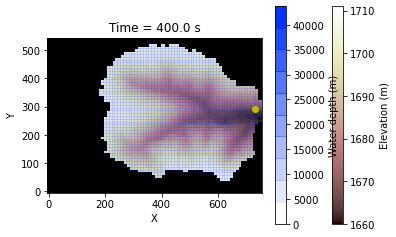

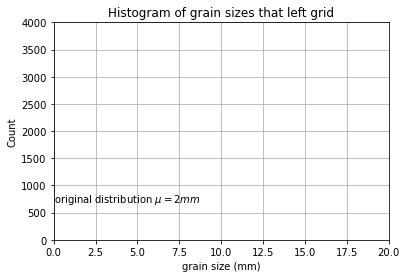

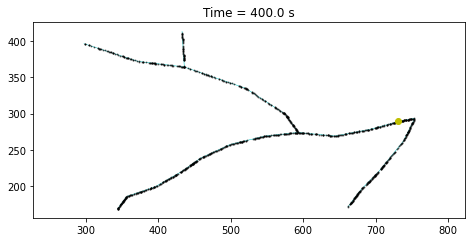

401.0
STORMMMM
402.0
403.0
404.0
405.0
406.0
407.0
408.0
409.0
410.0
411.0
412.0
413.0
414.0
415.0
416.0
417.0
418.0
419.0
420.0
421.0
422.0
423.0
424.0
425.0
426.0
427.0
428.0
429.0
430.0
STORMMMM
431.0
432.0
433.0
434.0
435.0
436.0
437.0
438.0
439.0
440.0
441.0
442.0
443.0
444.0
445.0
446.0
447.0
448.0
449.0
450.0
451.0
STORMMMM
452.0
453.0
454.0
455.0
456.0
457.0
458.0
459.0
460.0
461.0
462.0
463.0
464.0
465.0
466.0
467.0
468.0
469.0
470.0
471.0
472.0
473.0
474.0
475.0
476.0
477.0
478.0
479.0
480.0
STORMMMM
481.0
482.0
483.0
484.0
485.0
486.0
487.0
488.0
489.0
490.0
491.0
492.0
493.0
494.0
495.0
496.0
497.0
498.0
499.0
500.0
Sed transporter run at model time:  0.005787037037037037 days passed


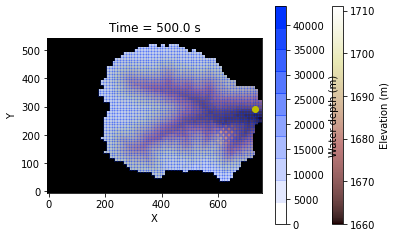

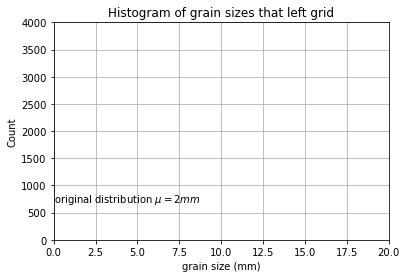

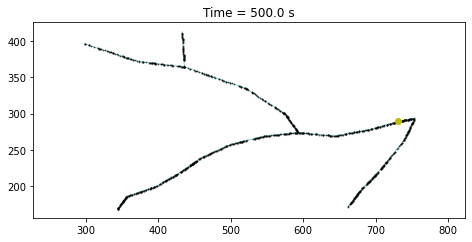

501.0
STORMMMM
502.0
503.0
504.0
505.0
506.0
507.0
508.0
509.0
510.0
511.0
512.0
513.0
514.0
515.0
516.0
517.0
518.0
519.0
520.0
521.0
522.0
523.0
524.0
525.0
526.0
527.0
528.0
529.0
530.0
STORMMMM
531.0
532.0
533.0
534.0
535.0
536.0
537.0
538.0
539.0
540.0
541.0
542.0
543.0
544.0
545.0
546.0
547.0
548.0
549.0
550.0
551.0
STORMMMM
552.0
553.0
554.0
555.0
556.0
557.0
558.0
559.0
560.0
561.0
562.0
563.0
564.0
565.0
566.0
567.0
568.0
569.0
570.0
571.0
572.0
573.0
574.0
575.0
576.0
577.0
578.0
579.0
580.0
STORMMMM
581.0
582.0
583.0
584.0
585.0
586.0
587.0
588.0
589.0
590.0
591.0
592.0
593.0
594.0
595.0
596.0
597.0
598.0
599.0
600.0
Sed transporter run at model time:  0.006944444444444444 days passed


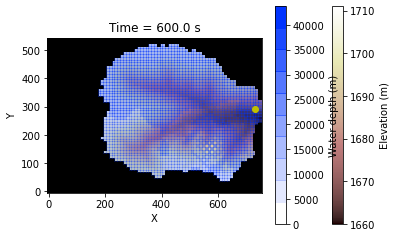

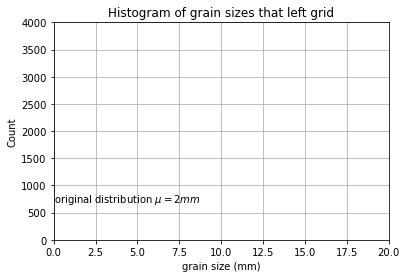

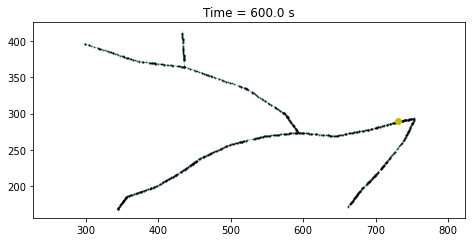

601.0
STORMMMM
602.0
603.0
604.0
605.0
606.0
607.0
608.0
609.0
610.0
611.0
612.0
613.0
614.0
615.0
616.0
617.0
618.0
619.0
620.0
621.0
622.0
623.0
624.0
625.0
626.0
627.0
628.0
629.0
630.0
STORMMMM
631.0
632.0
633.0
634.0
635.0
636.0
637.0
638.0
639.0
640.0
641.0
642.0
643.0
644.0
645.0
646.0
647.0
648.0
649.0
650.0
651.0
STORMMMM
652.0
653.0
654.0
655.0
656.0
657.0
658.0
659.0
660.0
661.0
662.0
663.0
664.0
665.0
666.0
667.0
668.0
669.0
670.0
671.0
672.0
673.0
674.0
675.0
676.0
677.0
678.0
679.0
680.0
STORMMMM
681.0
682.0
683.0
684.0
685.0
686.0
687.0
688.0
689.0
690.0
691.0
692.0
693.0
694.0
695.0
696.0
697.0
698.0
699.0
700.0
Sed transporter run at model time:  0.008101851851851851 days passed


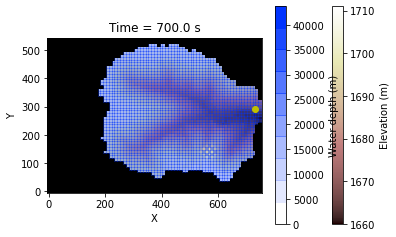

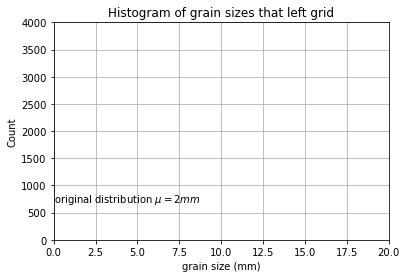

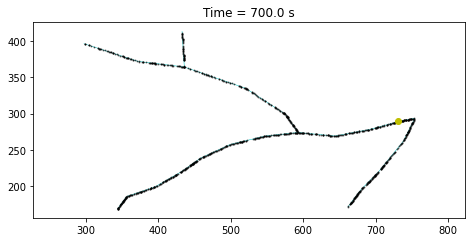

701.0
STORMMMM
702.0
703.0
704.0
705.0
706.0
707.0
708.0
709.0
710.0
711.0
712.0
713.0
714.0
715.0
716.0
717.0
718.0
719.0
720.0
721.0
722.0
723.0
724.0
725.0
726.0
727.0
728.0
729.0
730.0
STORMMMM
731.0
732.0
733.0
734.0
735.0
736.0
737.0
738.0
739.0
740.0
741.0
742.0
743.0
744.0
745.0
746.0
747.0
748.0
749.0
750.0
751.0
STORMMMM
752.0
753.0
754.0
755.0
756.0
757.0
758.0
759.0
760.0
761.0
762.0
763.0
764.0
765.0
766.0
767.0
768.0
769.0
770.0
771.0
772.0
773.0
774.0
775.0
776.0
777.0
778.0
779.0
780.0
STORMMMM
781.0
782.0
783.0
784.0
785.0
786.0
787.0
788.0
789.0
790.0
791.0
792.0
793.0
794.0
795.0
796.0
797.0
798.0
799.0
800.0
Sed transporter run at model time:  0.009259259259259259 days passed


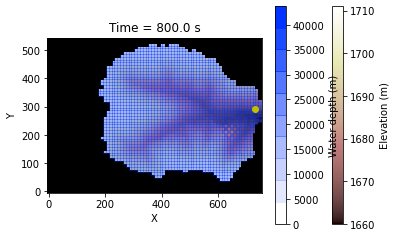

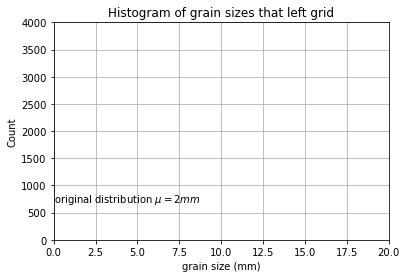

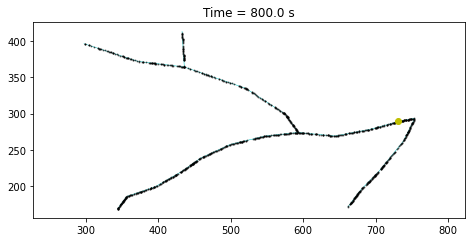

801.0
STORMMMM
802.0
803.0
804.0
805.0
806.0
807.0
808.0
809.0
810.0
811.0
812.0
813.0
814.0
815.0
816.0
817.0
818.0
819.0
820.0
821.0
822.0
823.0
824.0
825.0
826.0
827.0
828.0
829.0
830.0
STORMMMM
831.0
832.0
833.0
834.0
835.0
836.0
837.0
838.0
839.0
840.0
841.0
842.0
843.0
844.0
845.0
846.0
847.0
848.0
849.0
850.0
851.0
STORMMMM
852.0
853.0
854.0
855.0
856.0
857.0
858.0
859.0
860.0
861.0
862.0
863.0
864.0
865.0
866.0
867.0
868.0
869.0
870.0
871.0
872.0
873.0
874.0
875.0
876.0
877.0
878.0
879.0
880.0
STORMMMM
881.0
882.0
883.0
884.0
885.0
886.0
887.0
888.0
889.0
890.0
891.0
892.0
893.0
894.0
895.0
896.0
897.0
898.0
899.0
900.0
Sed transporter run at model time:  0.010416666666666666 days passed


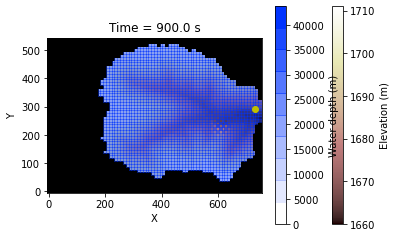

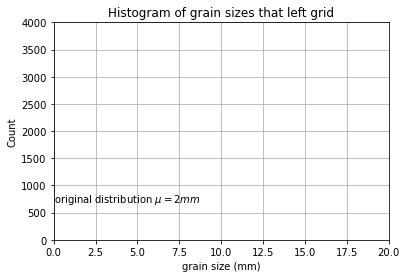

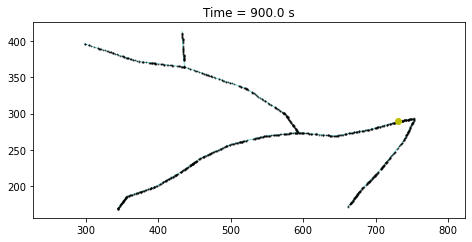

901.0
STORMMMM
902.0
903.0
904.0
905.0
906.0
907.0
908.0
909.0
910.0
911.0
912.0
913.0
914.0
915.0
916.0
917.0
918.0
919.0
920.0
921.0
922.0
923.0
924.0
925.0
926.0
927.0
928.0
929.0
930.0
STORMMMM
931.0
932.0
933.0
934.0
935.0
936.0
937.0
938.0
939.0
940.0
941.0
942.0
943.0
944.0
945.0
946.0
947.0
948.0
949.0
950.0
951.0
STORMMMM
952.0
953.0
954.0
955.0
956.0
957.0
958.0
959.0
960.0
961.0
962.0
963.0
964.0
965.0
966.0
967.0
968.0
969.0
970.0
971.0
972.0
973.0
974.0
975.0
976.0
977.0
978.0
979.0
980.0
STORMMMM
981.0
982.0
983.0
984.0
985.0
986.0
987.0
988.0
989.0
990.0
991.0
992.0
993.0
994.0
995.0
996.0
997.0
998.0
999.0
1000.0
Sed transporter run at model time:  0.011574074074074073 days passed


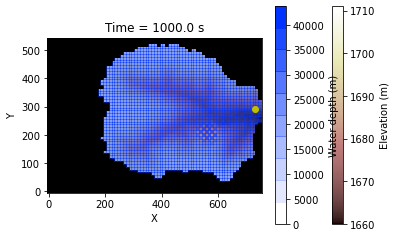

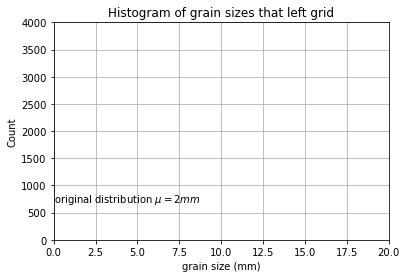

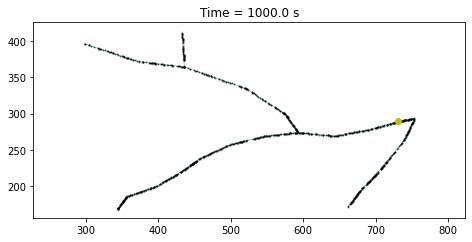

1001.0
STORMMMM
1002.0
1003.0
1004.0
1005.0
1006.0
1007.0
1008.0
1009.0
1010.0
1011.0
1012.0
1013.0
1014.0
1015.0
1016.0
1017.0
1018.0
1019.0
1020.0
1021.0
1022.0
1023.0
1024.0
1025.0
1026.0
1027.0
1028.0
1029.0
1030.0
STORMMMM
1031.0
1032.0
1033.0
1034.0
1035.0
1036.0
1037.0
1038.0
1039.0
1040.0
1041.0
1042.0
1043.0
1044.0
1045.0
1046.0
1047.0
1048.0
1049.0
1050.0
1051.0
STORMMMM
1052.0
1053.0
1054.0
1055.0
1056.0
1057.0
1058.0
1059.0
1060.0
1061.0
1062.0
1063.0
1064.0
1065.0
1066.0
1067.0
1068.0
1069.0
1070.0
1071.0
1072.0
1073.0
1074.0
1075.0
1076.0
1077.0
1078.0
1079.0
1080.0
STORMMMM
1081.0
1082.0
1083.0
1084.0
1085.0
1086.0
1087.0
1088.0
1089.0
1090.0
1091.0
1092.0
1093.0
1094.0
1095.0
1096.0
1097.0
1098.0
1099.0
1100.0
Sed transporter run at model time:  0.01273148148148148 days passed


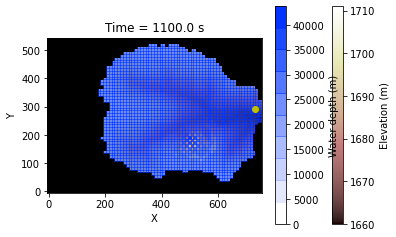

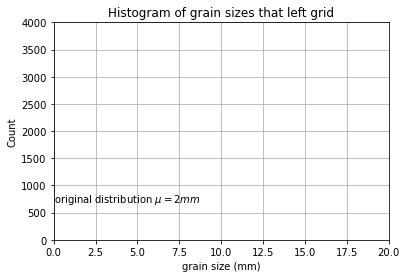

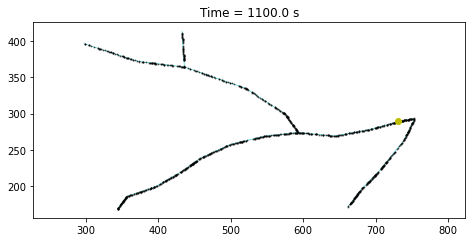

1101.0
STORMMMM
1102.0
1103.0
1104.0
1105.0
1106.0
1107.0
1108.0
1109.0
1110.0
1111.0
1112.0
1113.0
1114.0
1115.0
1116.0
1117.0
1118.0
1119.0
1120.0
1121.0
1122.0
1123.0
1124.0
1125.0
1126.0
1127.0
1128.0
1129.0
1130.0
STORMMMM
1131.0
1132.0
1133.0
1134.0
1135.0
1136.0
1137.0
1138.0
1139.0
1140.0
1141.0
1142.0
1143.0
1144.0
1145.0
1146.0
1147.0
1148.0
1149.0
1150.0
1151.0
STORMMMM
1152.0
1153.0
1154.0
1155.0
1156.0
1157.0
1158.0
1159.0
1160.0
1161.0
1162.0
1163.0
1164.0
1165.0
1166.0
1167.0
1168.0
1169.0
1170.0
1171.0
1172.0
1173.0
1174.0
1175.0
1176.0
1177.0
1178.0
1179.0
1180.0
STORMMMM
1181.0
1182.0
1183.0
1184.0
1185.0
1186.0
1187.0
1188.0
1189.0
1190.0
1191.0
1192.0
1193.0
1194.0
1195.0
1196.0
1197.0
1198.0
1199.0
1200.0
Sed transporter run at model time:  0.013888888888888888 days passed


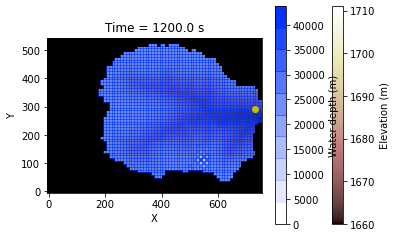

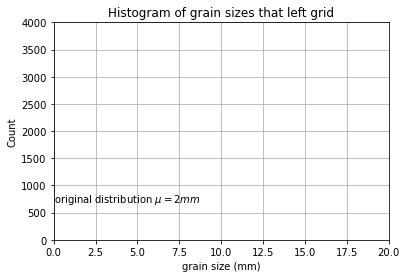

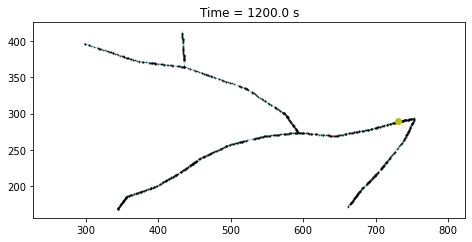

1201.0
STORMMMM
1202.0
1203.0
1204.0
1205.0
1206.0
1207.0
1208.0
1209.0
1210.0
1211.0
1212.0
1213.0
1214.0
1215.0
1216.0
1217.0
1218.0
1219.0
1220.0
1221.0
1222.0
1223.0
1224.0
1225.0
1226.0
1227.0
1228.0
1229.0
1230.0
STORMMMM
1231.0
1232.0
1233.0
1234.0
1235.0
1236.0
1237.0
1238.0
1239.0
1240.0
1241.0
1242.0
1243.0
1244.0
1245.0
1246.0
1247.0
1248.0
1249.0
1250.0
1251.0
STORMMMM
1252.0
1253.0
1254.0
1255.0
1256.0
1257.0
1258.0
1259.0
1260.0
1261.0
1262.0
1263.0
1264.0
1265.0
1266.0
1267.0
1268.0
1269.0
1270.0
1271.0
1272.0
1273.0
1274.0
1275.0
1276.0
1277.0
1278.0
1279.0
1280.0
STORMMMM
1281.0
1282.0
1283.0
1284.0
1285.0
1286.0
1287.0
1288.0
1289.0
1290.0
1291.0
1292.0
1293.0
1294.0
1295.0
1296.0
1297.0
1298.0
1299.0
1300.0
Sed transporter run at model time:  0.015046296296296295 days passed


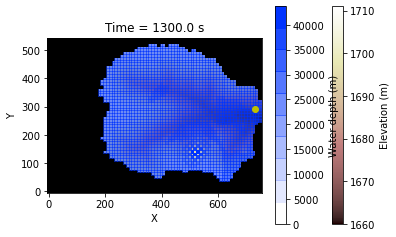

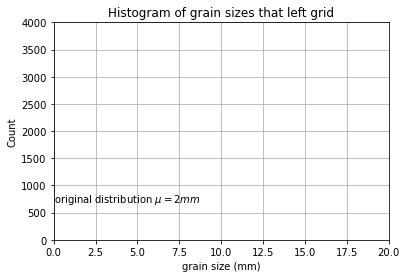

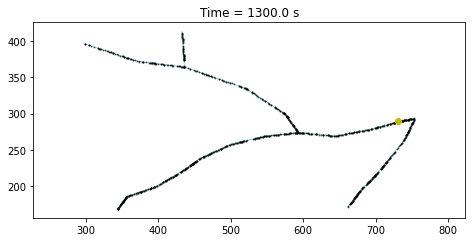

1301.0
STORMMMM
1302.0
1303.0
1304.0
1305.0
1306.0
1307.0
1308.0
1309.0
1310.0
1311.0
1312.0
1313.0
1314.0
1315.0
1316.0
1317.0
1318.0
1319.0
1320.0
1321.0
1322.0
1323.0
1324.0
1325.0
1326.0
1327.0
1328.0
1329.0
1330.0
STORMMMM
1331.0
1332.0
1333.0
1334.0
1335.0
1336.0
1337.0
1338.0
1339.0
1340.0
1341.0
1342.0
1343.0
1344.0
1345.0
1346.0
1347.0
1348.0
1349.0
1350.0
1351.0
STORMMMM
1352.0
1353.0
1354.0
1355.0
1356.0
1357.0
1358.0
1359.0
1360.0
1361.0
1362.0
1363.0
1364.0
1365.0
1366.0
1367.0
1368.0
1369.0
1370.0
1371.0
1372.0
1373.0
1374.0
1375.0
1376.0
1377.0
1378.0
1379.0
1380.0
STORMMMM
1381.0
1382.0
1383.0
1384.0
1385.0
1386.0
1387.0
1388.0
1389.0
1390.0
1391.0
1392.0
1393.0
1394.0
1395.0
1396.0
1397.0
1398.0
1399.0
1400.0
Sed transporter run at model time:  0.016203703703703703 days passed


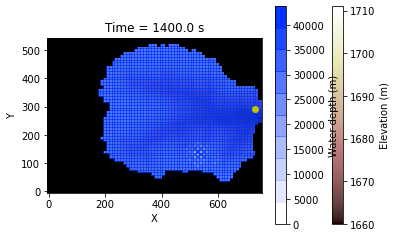

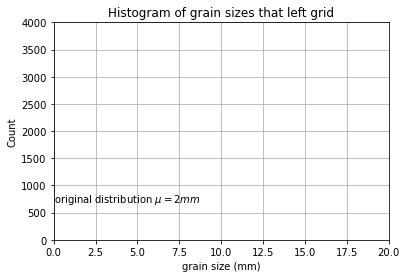

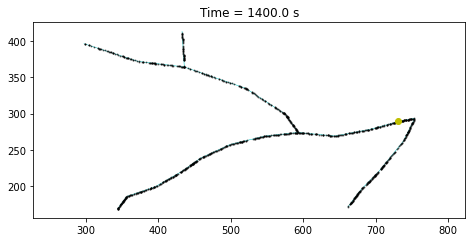

1401.0
STORMMMM
1402.0
1403.0
1404.0
1405.0
1406.0
1407.0
1408.0
1409.0
1410.0
1411.0
1412.0
1413.0
1414.0
1415.0
1416.0
1417.0
1418.0
1419.0
1420.0
1421.0
1422.0
1423.0
1424.0
1425.0
1426.0
1427.0
1428.0
1429.0
1430.0
STORMMMM
1431.0
1432.0
1433.0
1434.0
1435.0
1436.0
1437.0
1438.0
1439.0
1440.0
1441.0
1442.0
1443.0
1444.0
1445.0
1446.0
1447.0
1448.0
1449.0
1450.0
1451.0
STORMMMM
1452.0
1453.0
1454.0
1455.0
1456.0
1457.0
1458.0
1459.0
1460.0
1461.0
1462.0
1463.0
1464.0
1465.0
1466.0
1467.0
1468.0
1469.0
1470.0
1471.0
1472.0
1473.0
1474.0
1475.0
1476.0
1477.0
1478.0
1479.0
1480.0
STORMMMM
1481.0
1482.0
1483.0
1484.0
1485.0
1486.0
1487.0
1488.0
1489.0
1490.0
1491.0
1492.0
1493.0
1494.0
1495.0
1496.0
1497.0
1498.0
1499.0
1500.0
Sed transporter run at model time:  0.017361111111111112 days passed


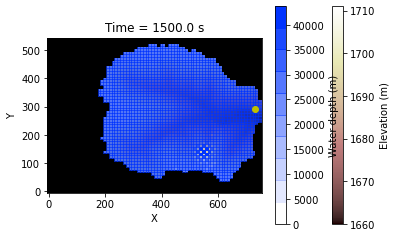

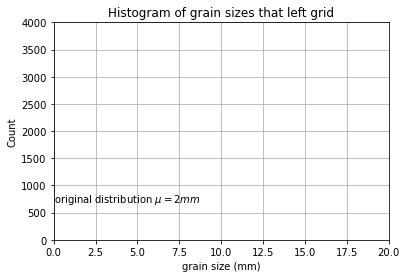

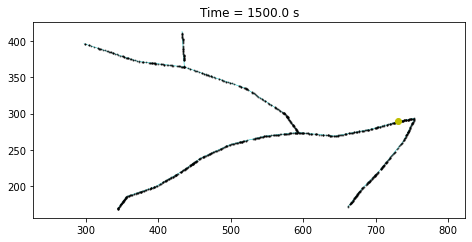

1501.0
STORMMMM
1502.0
1503.0
1504.0
1505.0
1506.0
1507.0
1508.0
1509.0
1510.0
1511.0
1512.0
1513.0
1514.0
1515.0
1516.0
1517.0
1518.0
1519.0
1520.0
1521.0
1522.0
1523.0
1524.0
1525.0
1526.0
1527.0
1528.0
1529.0
1530.0
STORMMMM
1531.0
1532.0
1533.0
1534.0
1535.0
1536.0
1537.0
1538.0
1539.0
1540.0
1541.0
1542.0
1543.0
1544.0
1545.0
1546.0
1547.0
1548.0
1549.0
1550.0
STORMMMM
1551.0
STORMMMM
1552.0
1553.0
1554.0
1555.0
1556.0
1557.0
1558.0
1559.0
1560.0
1561.0
1562.0
1563.0
1564.0
1565.0
1566.0
1567.0
1568.0
1569.0
1570.0
1571.0
1572.0
1573.0
1574.0
1575.0
1576.0
1577.0
1578.0
1579.0
1580.0
STORMMMM
1581.0
1582.0
1583.0
1584.0
1585.0
1586.0
1587.0
1588.0
1589.0
1590.0
1591.0
1592.0
1593.0
1594.0
1595.0
1596.0
1597.0
1598.0
1599.0
1600.0
Sed transporter run at model time:  0.018518518518518517 days passed


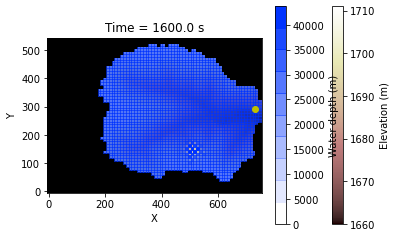

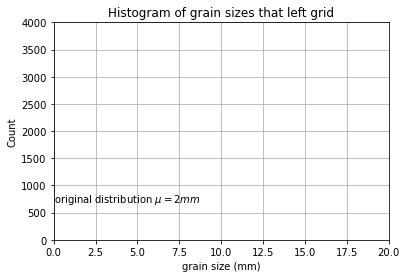

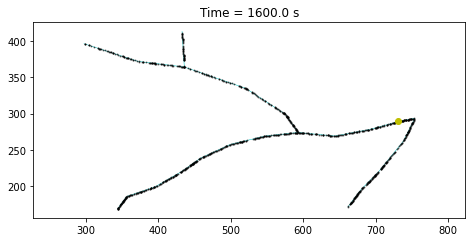

1601.0
STORMMMM
1602.0
1603.0
1604.0
1605.0
1606.0
1607.0
1608.0
1609.0
1610.0
1611.0
1612.0
1613.0
1614.0
1615.0
1616.0
1617.0
1618.0
1619.0
1620.0
1621.0
1622.0
1623.0
1624.0
1625.0
1626.0
1627.0
1628.0
1629.0
1630.0
STORMMMM
1631.0
1632.0
1633.0
1634.0
1635.0
1636.0
1637.0
1638.0
1639.0
1640.0
1641.0
1642.0
1643.0
1644.0
1645.0
1646.0
1647.0
1648.0
1649.0
1650.0
1651.0
STORMMMM
1652.0
1653.0
1654.0
1655.0
1656.0
1657.0
1658.0
1659.0
1660.0
1661.0
1662.0
1663.0
1664.0
1665.0
1666.0
1667.0
1668.0
1669.0
1670.0
1671.0
1672.0
1673.0
1674.0
1675.0
1676.0
1677.0
1678.0
1679.0
1680.0
STORMMMM
1681.0
1682.0
1683.0
1684.0
1685.0
1686.0
1687.0
1688.0
1689.0
1690.0
1691.0
1692.0
1693.0
1694.0
1695.0
1696.0
1697.0
1698.0
1699.0
1700.0
Sed transporter run at model time:  0.019675925925925927 days passed


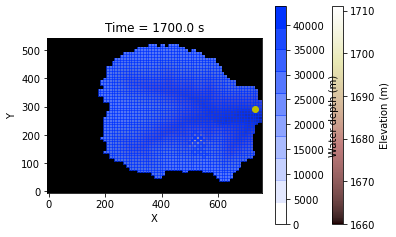

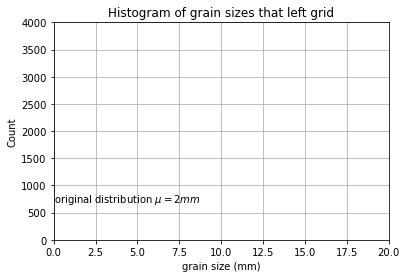

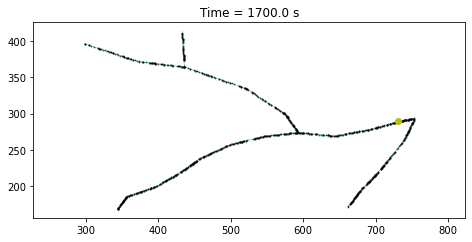

1701.0
STORMMMM
1702.0
1703.0
1704.0
1705.0
1706.0
1707.0
1708.0
1709.0
1710.0
1711.0
1712.0
1713.0
1714.0
1715.0
1716.0
1717.0
1718.0
1719.0
1720.0
1721.0
1722.0
1723.0
1724.0
1725.0
1726.0
1727.0
1728.0
1729.0
1730.0
STORMMMM
1731.0
1732.0
1733.0
1734.0
1735.0
1736.0
1737.0
1738.0
1739.0
1740.0
1741.0
1742.0
1743.0
1744.0
1745.0
1746.0
1747.0
1748.0
1749.0
1750.0
1751.0
STORMMMM
1752.0
1753.0
1754.0
1755.0
1756.0
1757.0
1758.0
1759.0
1760.0
1761.0
1762.0
1763.0
1764.0
1765.0
1766.0
1767.0
1768.0
1769.0
1770.0
1771.0
1772.0
1773.0
1774.0
1775.0
1776.0
1777.0
1778.0
1779.0
1780.0
STORMMMM
1781.0
1782.0
1783.0
1784.0
1785.0
1786.0
1787.0
1788.0
1789.0
1790.0
1791.0
1792.0
1793.0
1794.0
1795.0
1796.0
1797.0
1798.0
1799.0
1800.0
Sed transporter run at model time:  0.020833333333333332 days passed


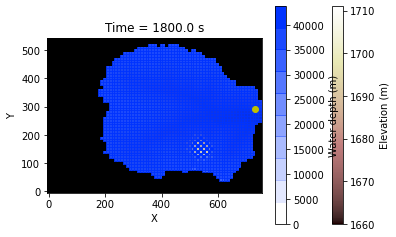

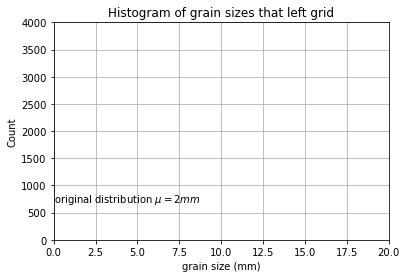

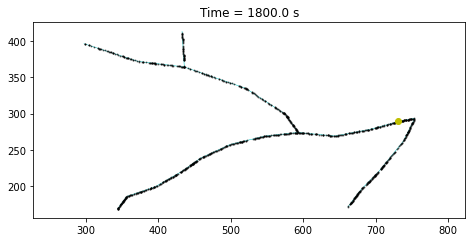

1801.0
STORMMMM
1802.0
1803.0
1804.0
1805.0
1806.0
1807.0
1808.0
1809.0
1810.0
1811.0
1812.0
1813.0
1814.0
1815.0
1816.0
1817.0
1818.0
1819.0
1820.0
1821.0
1822.0
1823.0
1824.0
1825.0
1826.0
1827.0
1828.0
1829.0
1830.0
STORMMMM
1831.0
1832.0
1833.0
1834.0
1835.0
1836.0
1837.0
1838.0
1839.0
1840.0
1841.0
1842.0
1843.0
1844.0
1845.0
1846.0
1847.0
1848.0
1849.0
1850.0
1851.0
STORMMMM
1852.0
1853.0
1854.0
1855.0
1856.0
1857.0
1858.0
1859.0
1860.0
1861.0
1862.0
1863.0
1864.0
1865.0
1866.0
1867.0
1868.0
1869.0
1870.0
1871.0
1872.0
1873.0
1874.0
1875.0
1876.0
1877.0
1878.0
1879.0
1880.0
STORMMMM
1881.0
1882.0
1883.0
1884.0
1885.0
1886.0
1887.0
1888.0
1889.0
1890.0
1891.0
1892.0
1893.0
1894.0
1895.0
1896.0
1897.0
1898.0
1899.0
1900.0
Sed transporter run at model time:  0.02199074074074074 days passed


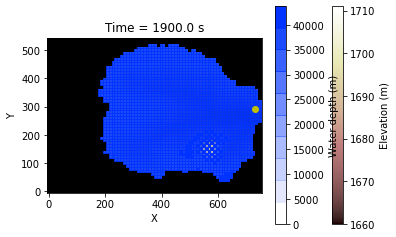

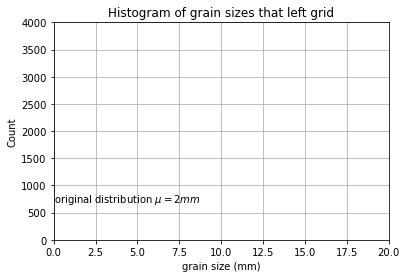

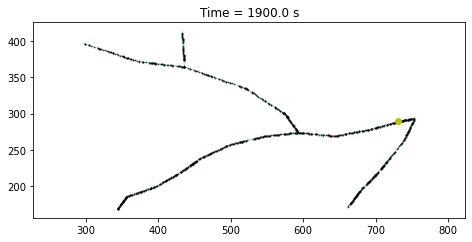

1901.0
STORMMMM
1902.0
1903.0
1904.0
1905.0
1906.0
1907.0
1908.0
1909.0
1910.0
1911.0
1912.0
1913.0
1914.0
1915.0
1916.0
1917.0
1918.0
1919.0
1920.0
1921.0
1922.0
1923.0
1924.0
1925.0
1926.0
1927.0
1928.0
1929.0
1930.0
STORMMMM
1931.0
1932.0
1933.0
1934.0
1935.0
1936.0
1937.0
1938.0
1939.0
1940.0
1941.0
1942.0
1943.0
1944.0
1945.0
1946.0
1947.0
1948.0
1949.0
1950.0
1951.0
STORMMMM
1952.0
1953.0
1954.0
1955.0
1956.0
1957.0
1958.0
1959.0
1960.0
1961.0
1962.0
1963.0
1964.0
1965.0
1966.0
1967.0
1968.0
1969.0
1970.0
1971.0
1972.0
1973.0
1974.0
1975.0
1976.0
1977.0
1978.0
1979.0
1980.0
STORMMMM
1981.0
1982.0
1983.0
1984.0
1985.0
1986.0
1987.0
1988.0
1989.0
1990.0
1991.0
1992.0
1993.0
1994.0
1995.0
1996.0
1997.0
1998.0
1999.0
2000.0
Sed transporter run at model time:  0.023148148148148147 days passed


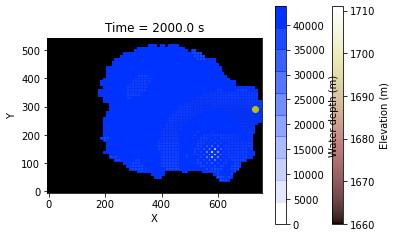

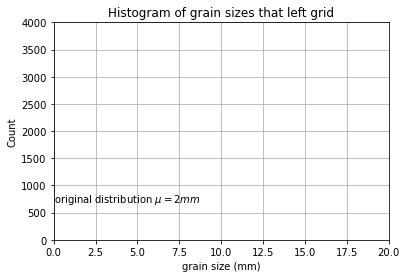

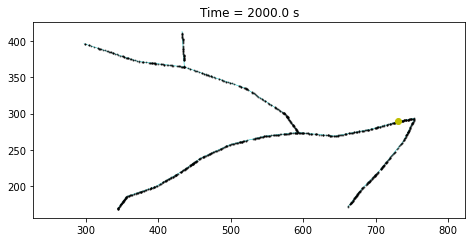

2001.0
STORMMMM
2002.0
2003.0
2004.0
2005.0
2006.0
2007.0
2008.0
2009.0
2010.0
2011.0
2012.0
2013.0
2014.0
2015.0
2016.0
2017.0
2018.0
2019.0
2020.0
2021.0
2022.0
2023.0
2024.0
2025.0
2026.0
2027.0
2028.0
2029.0
2030.0
STORMMMM
2031.0
2032.0
2033.0
2034.0
2035.0
2036.0
2037.0
2038.0
2039.0
2040.0
2041.0
2042.0
2043.0
2044.0
2045.0
2046.0
2047.0
2048.0
2049.0
2050.0
2051.0
STORMMMM
2052.0
2053.0
2054.0
2055.0
2056.0
2057.0
2058.0
2059.0
2060.0
2061.0
2062.0
2063.0
2064.0
2065.0
2066.0
2067.0
2068.0
2069.0
2070.0
2071.0
2072.0
2073.0
2074.0
2075.0
2076.0
2077.0
2078.0
2079.0
2080.0
STORMMMM
2081.0
2082.0
2083.0
2084.0
2085.0
2086.0
2087.0
2088.0
2089.0
2090.0
2091.0
2092.0
2093.0
2094.0
2095.0
2096.0
2097.0
2098.0
2099.0
2100.0
Sed transporter run at model time:  0.024305555555555556 days passed


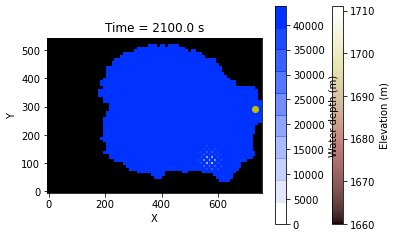

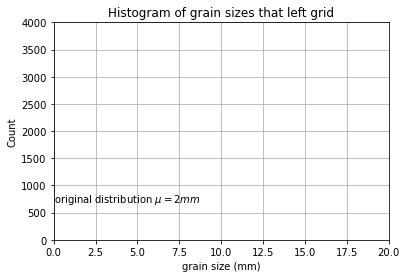

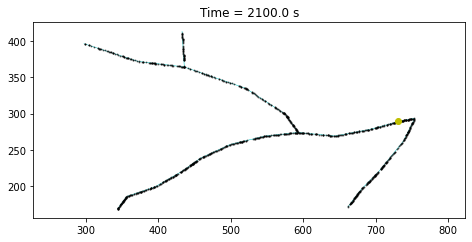

2101.0
STORMMMM
2102.0
2103.0
2104.0
2105.0
2106.0
2107.0
2108.0
2109.0
2110.0
2111.0
2112.0
2113.0
2114.0
2115.0
2116.0
2117.0
2118.0
2119.0
2120.0
2121.0
2122.0
2123.0
2124.0
2125.0
2126.0
2127.0
2128.0
2129.0
2130.0
STORMMMM
2131.0
2132.0
2133.0
2134.0
2135.0
2136.0
2137.0
2138.0
2139.0
2140.0
2141.0
2142.0
2143.0
2144.0
2145.0
2146.0
2147.0
2148.0
2149.0
2150.0
2151.0
STORMMMM
2152.0
2153.0
2154.0
2155.0
2156.0
2157.0
2158.0
2159.0
2160.0
2161.0
2162.0
2163.0
2164.0
2165.0
2166.0
2167.0
2168.0
2169.0
2170.0
2171.0
2172.0
2173.0
2174.0
2175.0
2176.0
2177.0
2178.0
2179.0
2180.0
STORMMMM
2181.0
2182.0
2183.0
2184.0
2185.0
2186.0
2187.0
2188.0
2189.0
2190.0
2191.0
2192.0
2193.0
2194.0
2195.0
2196.0
2197.0
2198.0
2199.0
2200.0
Sed transporter run at model time:  0.02546296296296296 days passed


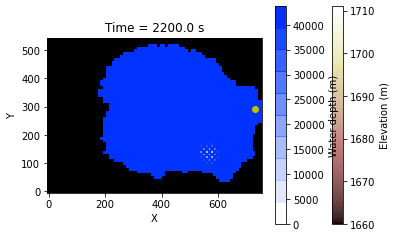

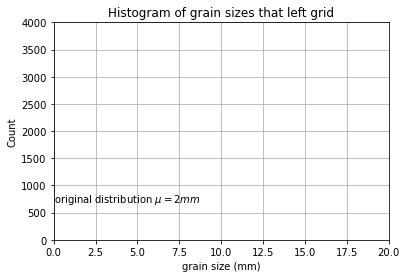

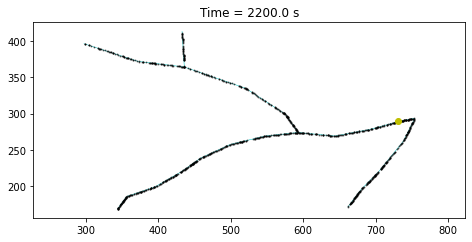

2201.0
STORMMMM
2202.0
2203.0
2204.0
2205.0
2206.0
2207.0
2208.0
2209.0
2210.0
2211.0
2212.0
2213.0
2214.0
2215.0
2216.0
2217.0
2218.0
2219.0
2220.0
2221.0
2222.0
2223.0
2224.0
2225.0
2226.0
2227.0
2228.0
2229.0
2230.0
STORMMMM
2231.0
2232.0
2233.0
2234.0
2235.0
2236.0
2237.0
2238.0
2239.0
2240.0
2241.0
2242.0
2243.0
2244.0
2245.0
2246.0
2247.0
2248.0
2249.0
2250.0
2251.0
STORMMMM
2252.0
2253.0
2254.0
2255.0
2256.0
2257.0
2258.0
2259.0
2260.0
2261.0
2262.0
2263.0
2264.0
2265.0
2266.0
2267.0
2268.0
2269.0
2270.0
2271.0
2272.0
2273.0
2274.0
2275.0
2276.0
2277.0
2278.0
2279.0
2280.0
STORMMMM
2281.0
2282.0
2283.0
2284.0
2285.0
2286.0
2287.0
2288.0
2289.0
2290.0
2291.0
2292.0
2293.0
2294.0
2295.0
2296.0
2297.0
2298.0
2299.0
2300.0
Sed transporter run at model time:  0.02662037037037037 days passed


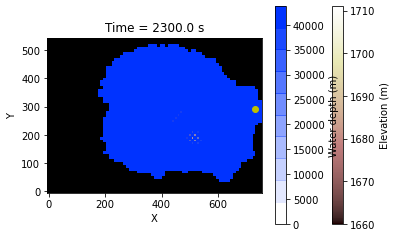

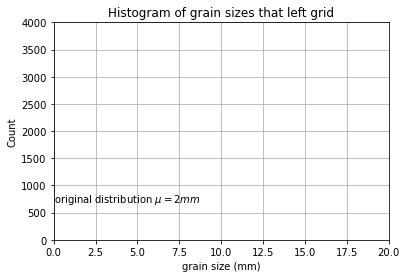

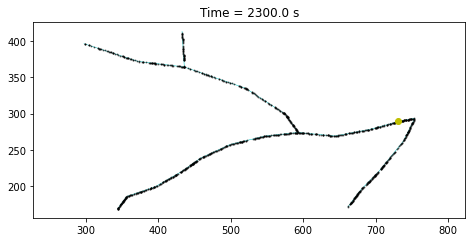

2301.0
STORMMMM
2302.0
2303.0
2304.0
2305.0
2306.0
2307.0
2308.0
2309.0
2310.0
2311.0
2312.0
2313.0
2314.0
2315.0
2316.0
2317.0
2318.0
2319.0
2320.0
2321.0
2322.0
2323.0
2324.0
2325.0
2326.0
2327.0
2328.0
2329.0
2330.0
STORMMMM
2331.0
2332.0
2333.0
2334.0
2335.0
2336.0
2337.0
2338.0
2339.0
2340.0
2341.0
2342.0
2343.0
2344.0
2345.0
2346.0
2347.0
2348.0
2349.0
2350.0
2351.0
STORMMMM
2352.0
2353.0
2354.0
2355.0
2356.0
2357.0
2358.0
2359.0
2360.0
2361.0
2362.0
2363.0
2364.0
2365.0
2366.0
2367.0
2368.0
2369.0
2370.0
2371.0
2372.0
2373.0
2374.0
2375.0
2376.0
2377.0
2378.0
2379.0
2380.0
STORMMMM
2381.0
2382.0
2383.0
2384.0
2385.0
2386.0
2387.0
2388.0
2389.0
2390.0
2391.0
2392.0
2393.0
2394.0
2395.0
2396.0
2397.0
2398.0
2399.0
2400.0
Sed transporter run at model time:  0.027777777777777776 days passed


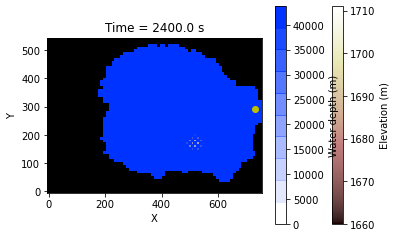

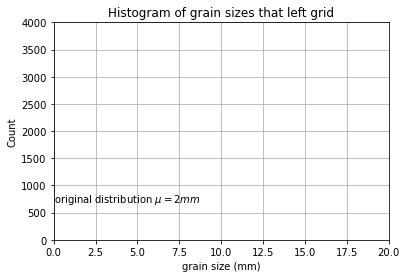

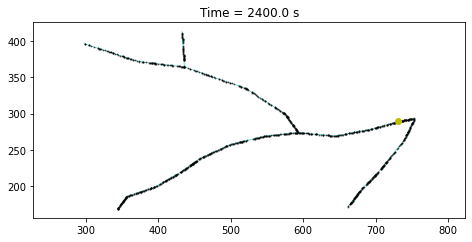

2401.0
STORMMMM
2402.0
2403.0
2404.0
2405.0
2406.0
2407.0
2408.0
2409.0
2410.0
2411.0
2412.0
2413.0
2414.0
2415.0
2416.0
2417.0
2418.0
2419.0
2420.0
2421.0
2422.0
2423.0
2424.0
2425.0
2426.0
2427.0
2428.0
2429.0
2430.0
STORMMMM
2431.0
2432.0
2433.0
2434.0
2435.0
2436.0
2437.0
2438.0
2439.0
2440.0
2441.0
2442.0
2443.0
2444.0
2445.0
2446.0
2447.0
2448.0
2449.0
2450.0
2451.0
STORMMMM
2452.0
2453.0
2454.0
2455.0
2456.0
2457.0
2458.0
2459.0
2460.0
2461.0
2462.0
2463.0
2464.0
2465.0
2466.0
2467.0
2468.0
2469.0
2470.0
2471.0
2472.0
2473.0
2474.0
2475.0
2476.0
2477.0
2478.0
2479.0
2480.0
STORMMMM
2481.0
2482.0
2483.0
2484.0
2485.0
2486.0
2487.0
2488.0
2489.0
2490.0
2491.0
2492.0
2493.0
2494.0
2495.0
2496.0
2497.0
2498.0
2499.0
2500.0
Sed transporter run at model time:  0.028935185185185185 days passed


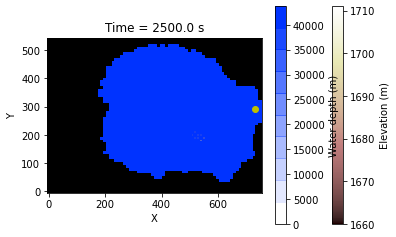

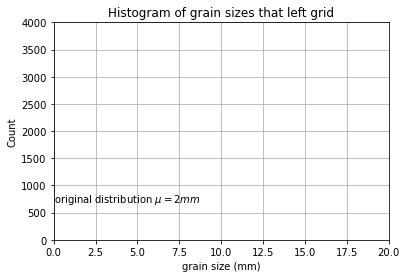

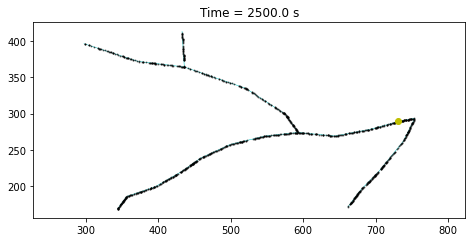

2501.0
STORMMMM
2502.0
2503.0
2504.0
2505.0
2506.0
2507.0
2508.0
2509.0
2510.0
2511.0
2512.0
2513.0
2514.0
2515.0
2516.0
2517.0
2518.0
2519.0
2520.0
2521.0
2522.0
2523.0
2524.0
2525.0
2526.0
2527.0
2528.0
2529.0
2530.0
STORMMMM
2531.0
2532.0
2533.0
2534.0
2535.0
2536.0
2537.0
2538.0
2539.0
2540.0
2541.0
2542.0
2543.0
2544.0
2545.0
2546.0
2547.0
2548.0
2549.0
2550.0
2551.0
STORMMMM
2552.0
2553.0
2554.0
2555.0
2556.0
2557.0
2558.0
2559.0
2560.0
2561.0
2562.0
2563.0
2564.0
2565.0
2566.0
2567.0
2568.0
2569.0
2570.0
2571.0
2572.0
2573.0
2574.0
2575.0
2576.0
2577.0
2578.0
2579.0
2580.0
STORMMMM
2581.0
2582.0
2583.0
2584.0
2585.0
2586.0
2587.0
2588.0
2589.0
2590.0
2591.0
2592.0
2593.0
2594.0
2595.0
2596.0
2597.0
2598.0
2599.0
2600.0
Sed transporter run at model time:  0.03009259259259259 days passed


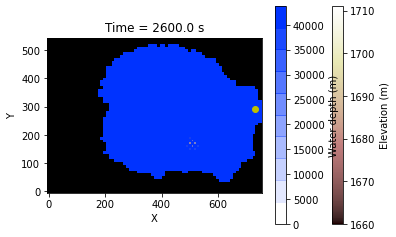

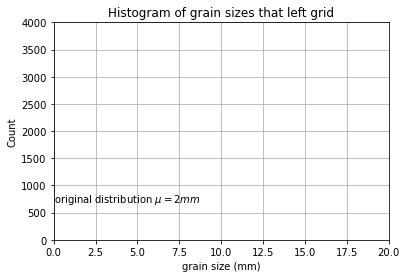

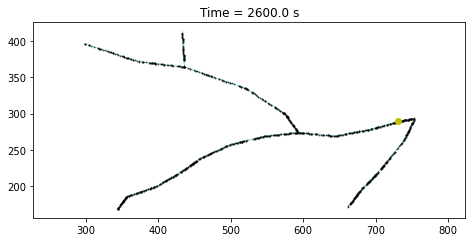

2601.0
STORMMMM
2602.0
2603.0
2604.0
2605.0
2606.0
2607.0
2608.0
2609.0
2610.0
2611.0
2612.0
2613.0
2614.0
2615.0
2616.0
2617.0
2618.0
2619.0
2620.0
2621.0
2622.0
2623.0
2624.0
2625.0
2626.0
2627.0
2628.0
2629.0
2630.0
STORMMMM
2631.0
2632.0
2633.0
2634.0
2635.0
2636.0
2637.0
2638.0
2639.0
2640.0
2641.0
2642.0
2643.0
2644.0
2645.0
2646.0
2647.0
2648.0
2649.0
2650.0
2651.0
STORMMMM
2652.0
2653.0
2654.0
2655.0
2656.0
2657.0
2658.0
2659.0
2660.0
2661.0
2662.0
2663.0
2664.0
2665.0
2666.0
2667.0
2668.0
2669.0
2670.0
2671.0
2672.0
2673.0
2674.0
2675.0
2676.0
2677.0
2678.0
2679.0
2680.0
STORMMMM
2681.0
2682.0
2683.0
2684.0
2685.0
2686.0
2687.0
2688.0
2689.0
2690.0
2691.0
2692.0
2693.0
2694.0
2695.0
2696.0
2697.0
2698.0
2699.0
2700.0
Sed transporter run at model time:  0.03125 days passed


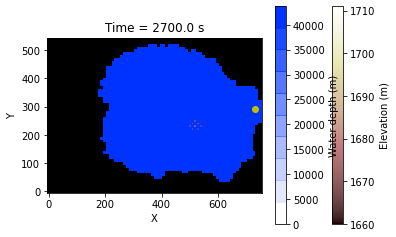

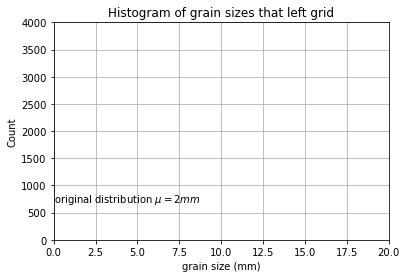

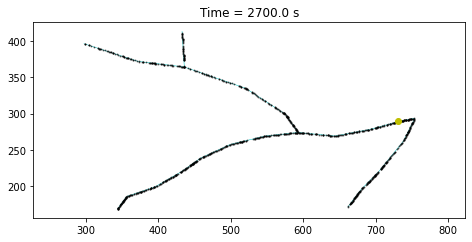

2701.0
STORMMMM
2702.0
2703.0
2704.0
2705.0
2706.0
2707.0
2708.0
2709.0
2710.0
2711.0
2712.0
2713.0
2714.0
2715.0
2716.0
2717.0
2718.0
2719.0
2720.0
2721.0
2722.0
2723.0
2724.0
2725.0
2726.0
2727.0
2728.0
2729.0
2730.0
STORMMMM
2731.0
2732.0
2733.0
2734.0
2735.0
2736.0
2737.0
2738.0
2739.0
2740.0
2741.0
2742.0
2743.0
2744.0
2745.0
2746.0
2747.0
2748.0
2749.0
2750.0
2751.0
STORMMMM
2752.0
2753.0
2754.0
2755.0
2756.0
2757.0
2758.0
2759.0
2760.0
2761.0
2762.0
2763.0
2764.0
2765.0
2766.0
2767.0
2768.0
2769.0
2770.0
2771.0
2772.0
2773.0
2774.0
2775.0
2776.0
2777.0
2778.0
2779.0
STORMMMM
2780.0
2781.0
2782.0
2783.0
2784.0
2785.0
2786.0
2787.0
2788.0
2789.0
2790.0
2791.0
2792.0
2793.0
2794.0
2795.0
2796.0
2797.0
2798.0
2799.0
2800.0
STORMMMM
Sed transporter run at model time:  0.032407407407407406 days passed


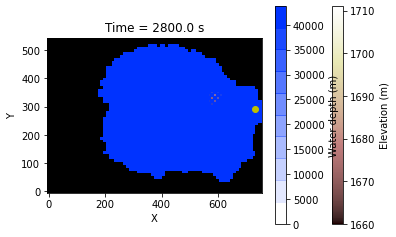

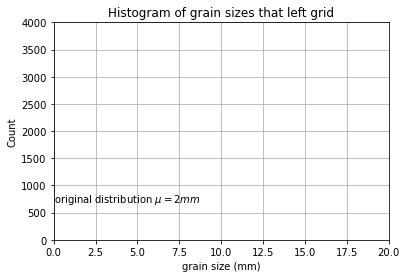

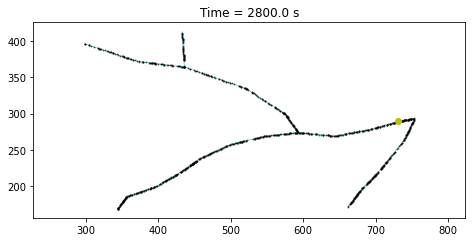

2801.0
2802.0
2803.0
2804.0
2805.0
2806.0
2807.0
2808.0
2809.0
2810.0
2811.0
2812.0
2813.0
2814.0
2815.0
2816.0
2817.0
2818.0
2819.0
2820.0
2821.0
2822.0
2823.0
2824.0
2825.0
2826.0
2827.0
2828.0
2829.0
STORMMMM
2830.0
2831.0
2832.0
2833.0
2834.0
2835.0
2836.0
2837.0
2838.0
2839.0
2840.0
2841.0
2842.0
2843.0
2844.0
2845.0
2846.0
2847.0
2848.0
2849.0
2850.0
STORMMMM
2851.0
2852.0
2853.0
2854.0
2855.0
2856.0
2857.0
2858.0
2859.0
2860.0
2861.0
2862.0
2863.0
2864.0
2865.0
2866.0
2867.0
2868.0
2869.0
2870.0
2871.0
2872.0
2873.0
2874.0
2875.0
2876.0
2877.0
2878.0
2879.0
STORMMMM
2880.0
2881.0
2882.0
2883.0
2884.0
2885.0
2886.0
2887.0
2888.0
2889.0
2890.0
2891.0
2892.0
2893.0
2894.0
2895.0
2896.0
2897.0
2898.0
2899.0
2900.0
STORMMMM
Sed transporter run at model time:  0.03356481481481482 days passed


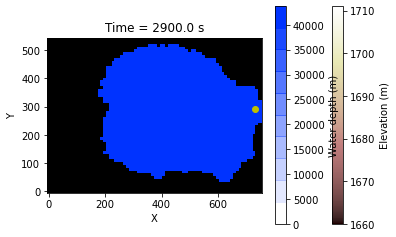

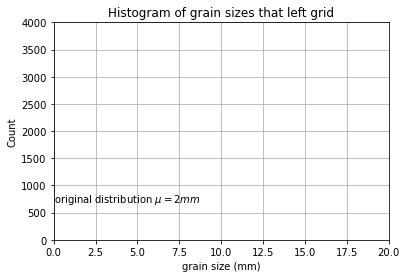

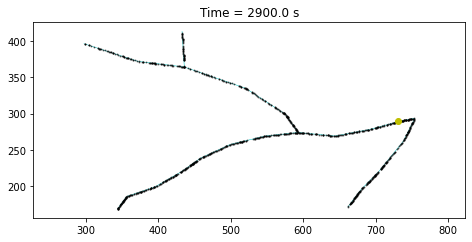

2901.0
2902.0
2903.0
2904.0
2905.0
2906.0
2907.0
2908.0
2909.0
2910.0
2911.0
2912.0
2913.0
2914.0
2915.0
2916.0
2917.0
2918.0
2919.0
2920.0
2921.0
2922.0
2923.0
2924.0
2925.0
2926.0
2927.0
2928.0
2929.0
STORMMMM
2930.0
2931.0
2932.0
2933.0
2934.0
2935.0
2936.0
2937.0
2938.0
2939.0
2940.0
2941.0
2942.0
2943.0
2944.0
2945.0
2946.0
2947.0
2948.0
2949.0
2950.0
STORMMMM
2951.0
2952.0
2953.0
2954.0
2955.0
2956.0
2957.0
2958.0
2959.0
2960.0
2961.0
2962.0
2963.0
2964.0
2965.0
2966.0
2967.0
2968.0
2969.0
2970.0
2971.0
2972.0
2973.0
2974.0
2975.0
2976.0
2977.0
2978.0
2979.0
STORMMMM
2980.0
2981.0
2982.0
2983.0
2984.0
2985.0
2986.0
2987.0
2988.0
2989.0
2990.0
2991.0
2992.0
2993.0
2994.0
2995.0
2996.0
2997.0
2998.0
2999.0
3000.0
STORMMMM
Sed transporter run at model time:  0.034722222222222224 days passed


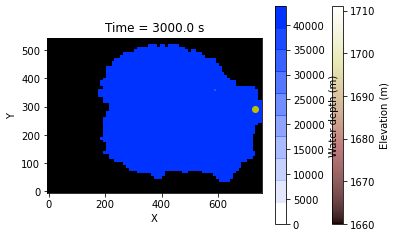

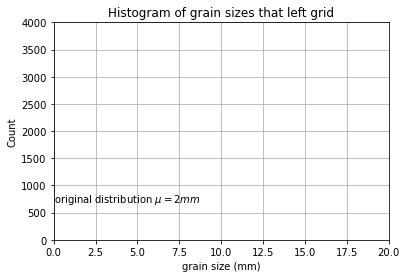

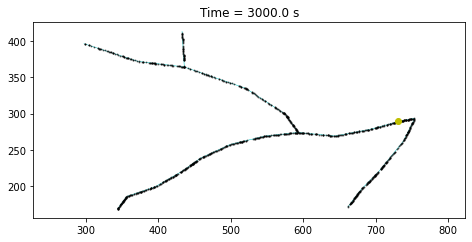

3001.0
3002.0
3003.0
3004.0
3005.0
3006.0
3007.0
3008.0
3009.0
3010.0
3011.0
3012.0
3013.0
3014.0
3015.0
3016.0
3017.0
3018.0
3019.0
3020.0
3021.0
3022.0
3023.0
3024.0
3025.0
3026.0
3027.0
3028.0
3029.0
STORMMMM
3030.0
3031.0
3032.0
3033.0
3034.0
3035.0
3036.0
3037.0
3038.0
3039.0
3040.0
3041.0
3042.0
3043.0
3044.0
3045.0
3046.0
3047.0
3048.0
3049.0
3050.0
STORMMMM
3051.0
3052.0
3053.0
3054.0
3055.0
3056.0
3057.0
3058.0
3059.0
3060.0
3061.0
3062.0
3063.0
3064.0
3065.0
3066.0
3067.0
3068.0
3069.0
3070.0
3071.0
3072.0
3073.0
3074.0
3075.0
3076.0
3077.0
3078.0
3079.0
STORMMMM
3080.0
3081.0
3082.0
3083.0
3084.0
3085.0
3086.0
3087.0
3088.0
3089.0
3090.0
3091.0
3092.0
3093.0
3094.0
3095.0
3096.0
3097.0
3098.0
3099.0
3100.0
STORMMMM
Sed transporter run at model time:  0.03587962962962963 days passed


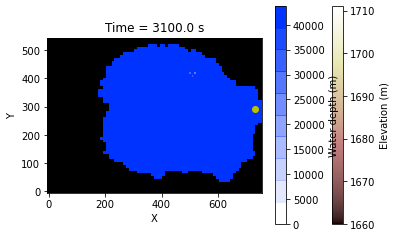

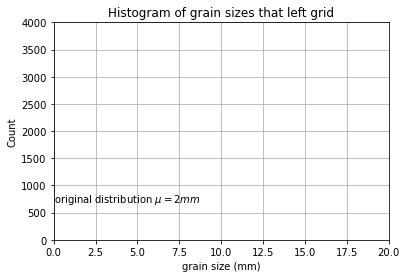

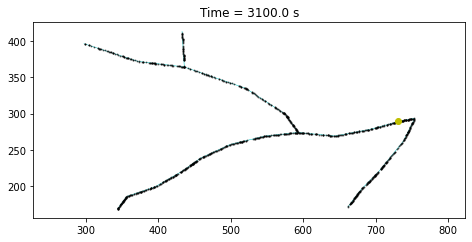

3101.0
3102.0
3103.0
3104.0
3105.0
3106.0
3107.0
3108.0
3109.0
3110.0
3111.0
3112.0
3113.0
3114.0
3115.0
3116.0
3117.0
3118.0
3119.0
3120.0
3121.0
3122.0
3123.0
3124.0
3125.0
3126.0
3127.0
3128.0
3129.0
STORMMMM
3130.0
3131.0
3132.0
3133.0
3134.0
3135.0
3136.0
3137.0
3138.0
3139.0
3140.0
3141.0
3142.0
3143.0
3144.0
3145.0
3146.0
3147.0
3148.0
3149.0
3150.0
STORMMMM
3151.0
3152.0
3153.0
3154.0
3155.0
STORMMMM
3156.0
3157.0
3158.0
3159.0
3160.0
3161.0
3162.0
3163.0
3164.0
3165.0
3166.0
3167.0
3168.0
3169.0
3170.0
3171.0
3172.0
3173.0
3174.0
3175.0
3176.0
3177.0
3178.0
3179.0
STORMMMM
3180.0
3181.0
3182.0
3183.0
3184.0
3185.0
3186.0
3187.0
3188.0
3189.0
3190.0
3191.0
3192.0
3193.0
3194.0
3195.0
3196.0
3197.0
3198.0
3199.0
3200.0
STORMMMM
Sed transporter run at model time:  0.037037037037037035 days passed


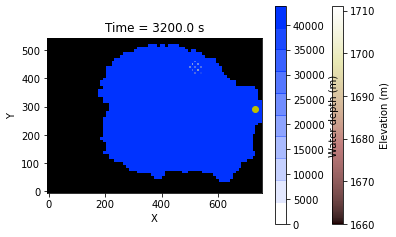

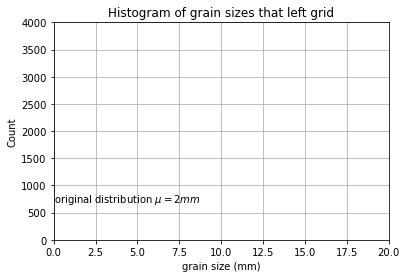

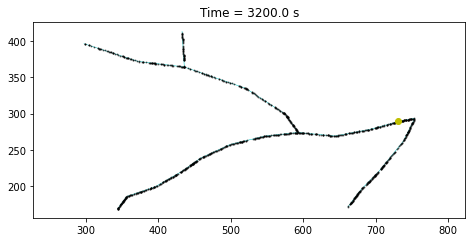

3201.0
3202.0
3203.0
3204.0
3205.0
3206.0
3207.0
3208.0
3209.0
3210.0
3211.0
3212.0
3213.0
3214.0
3215.0
3216.0
3217.0
3218.0
3219.0
3220.0
3221.0
3222.0
3223.0
3224.0
3225.0
3226.0
3227.0
3228.0
3229.0
STORMMMM
3230.0
3231.0
3232.0
3233.0
3234.0
3235.0
3236.0
3237.0
3238.0
3239.0
3240.0
3241.0
3242.0
3243.0
3244.0
3245.0
3246.0
3247.0
3248.0
3249.0
3250.0
STORMMMM
3251.0
3252.0
3253.0
3254.0
3255.0
3256.0
3257.0
3258.0
3259.0
3260.0
3261.0
3262.0
3263.0
3264.0
3265.0
3266.0
3267.0
3268.0
3269.0
3270.0
3271.0
3272.0
3273.0
3274.0
3275.0
3276.0
3277.0
3278.0
3279.0
STORMMMM
3280.0
3281.0
3282.0
3283.0
3284.0
3285.0
3286.0
3287.0
3288.0
3289.0
3290.0
3291.0
3292.0
3293.0
3294.0
3295.0
3296.0
3297.0
3298.0
3299.0
3300.0
STORMMMM
Sed transporter run at model time:  0.03819444444444445 days passed


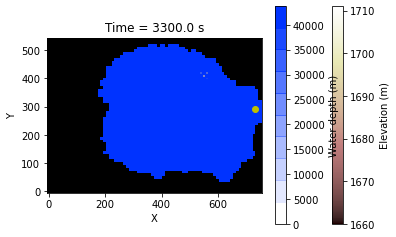

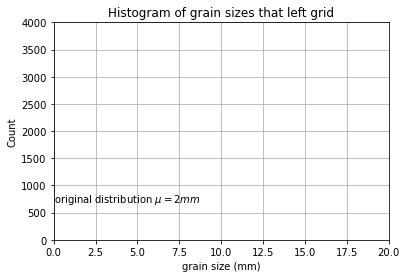

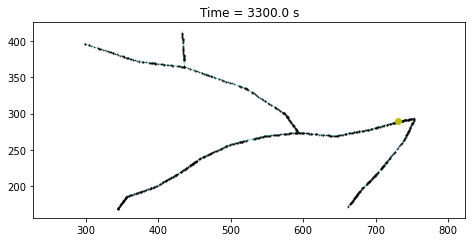

3301.0
3302.0
3303.0
3304.0
3305.0
3306.0
3307.0
3308.0
3309.0
3310.0
3311.0
3312.0
3313.0
3314.0
3315.0
3316.0
3317.0
3318.0
3319.0
3320.0
3321.0
3322.0
3323.0
3324.0
3325.0
3326.0
3327.0
3328.0
3329.0
STORMMMM
3330.0
3331.0
3332.0
3333.0
3334.0
3335.0
3336.0
3337.0
3338.0
3339.0
3340.0
3341.0
3342.0
3343.0
3344.0
3345.0
3346.0
3347.0
3348.0
3349.0
3350.0
STORMMMM
3351.0
3352.0
3353.0
3354.0
3355.0
3356.0
3357.0
3358.0
3359.0
3360.0
3361.0
3362.0
3363.0
3364.0
3365.0
3366.0
3367.0
3368.0
3369.0
3370.0
3371.0
3372.0
3373.0
3374.0
3375.0
3376.0
3377.0
3378.0
3379.0
STORMMMM
3380.0
3381.0
3382.0
3383.0
3384.0
3385.0
3386.0
3387.0
3388.0
3389.0
3390.0
3391.0
3392.0
3393.0
3394.0
3395.0
3396.0
3397.0
3398.0
3399.0
3400.0
STORMMMM
Sed transporter run at model time:  0.03935185185185185 days passed


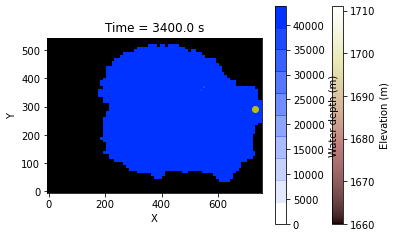

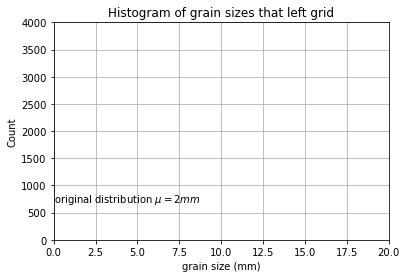

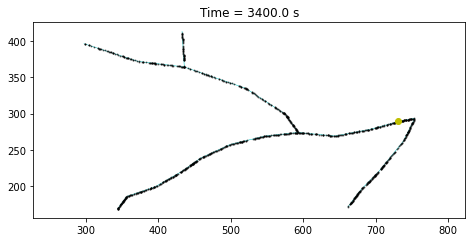

3401.0
3402.0
3403.0
3404.0
3405.0
3406.0
3407.0
3408.0
3409.0
3410.0
3411.0
3412.0
3413.0
3414.0
3415.0
3416.0
3417.0
3418.0
3419.0
3420.0
3421.0
3422.0
3423.0
3424.0
3425.0
3426.0
3427.0
3428.0
3429.0
STORMMMM
3430.0
3431.0
3432.0
3433.0
3434.0
3435.0
3436.0
3437.0
3438.0
3439.0
3440.0
3441.0
3442.0
3443.0
3444.0
3445.0
3446.0
3447.0
3448.0
3449.0
3450.0
STORMMMM
3451.0
3452.0
3453.0
3454.0
3455.0
3456.0
3457.0
3458.0
3459.0
3460.0
3461.0
3462.0
3463.0
3464.0
3465.0
3466.0
3467.0
3468.0
3469.0
3470.0
3471.0
3472.0
3473.0
3474.0
3475.0
3476.0
3477.0
3478.0
3479.0
STORMMMM
3480.0
3481.0
3482.0
3483.0
3484.0
3485.0
3486.0
3487.0
3488.0
3489.0
3490.0
3491.0
3492.0
3493.0
3494.0
3495.0
3496.0
3497.0
3498.0
3499.0
3500.0
STORMMMM
Sed transporter run at model time:  0.04050925925925926 days passed


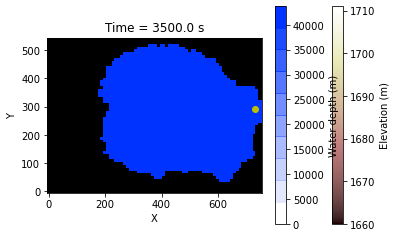

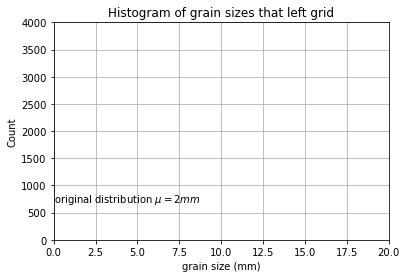

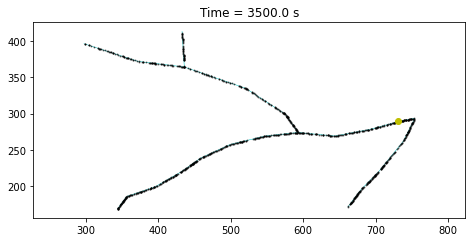

3501.0
3502.0
3503.0
3504.0
3505.0
STORMMMM
3506.0
3507.0
3508.0
3509.0
3510.0
3511.0
3512.0
3513.0
3514.0
3515.0
3516.0
3517.0
3518.0
3519.0
3520.0
3521.0
3522.0
3523.0
3524.0
3525.0
3526.0
3527.0
3528.0
3529.0
STORMMMM
3530.0
3531.0
3532.0
3533.0
3534.0
3535.0
3536.0
3537.0
3538.0
3539.0
3540.0
3541.0
3542.0
3543.0
3544.0
3545.0
3546.0
3547.0
3548.0
3549.0
3550.0
STORMMMM
3551.0
3552.0
3553.0
3554.0
3555.0
3556.0
3557.0
3558.0
3559.0
3560.0
3561.0
3562.0
3563.0
3564.0
3565.0
3566.0
3567.0
3568.0
3569.0
3570.0
3571.0
3572.0
3573.0
3574.0
3575.0
3576.0
3577.0
3578.0
3579.0
STORMMMM
3580.0
3581.0
3582.0
3583.0
3584.0
3585.0
3586.0
3587.0
3588.0
3589.0
3590.0
3591.0
3592.0
3593.0
3594.0
3595.0
3596.0
3597.0
3598.0
3599.0
3600.0
STORMMMM
Sed transporter run at model time:  0.041666666666666664 days passed


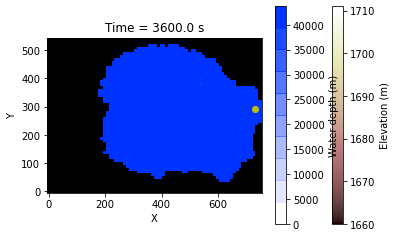

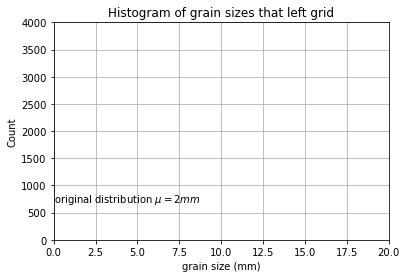

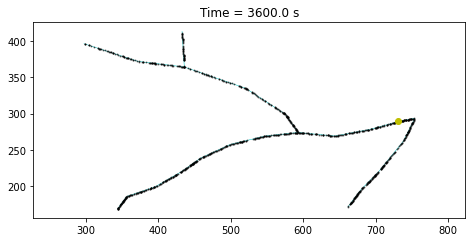

3601.0
3602.0
3603.0
3604.0
3605.0
3606.0
3607.0
3608.0
3609.0
3610.0
3611.0
3612.0
3613.0
3614.0
3615.0
3616.0
3617.0
3618.0
3619.0
3620.0
3621.0
3622.0
3623.0
3624.0
3625.0
3626.0
3627.0
3628.0
3629.0
STORMMMM
3630.0
3631.0
3632.0
3633.0
3634.0
3635.0
3636.0
3637.0
3638.0
3639.0
3640.0
3641.0
3642.0
3643.0
3644.0
3645.0
3646.0
3647.0
3648.0
3649.0
3650.0
STORMMMM
3651.0
3652.0
3653.0
3654.0
3655.0
3656.0
3657.0
3658.0
3659.0
3660.0
3661.0
3662.0
3663.0
3664.0
3665.0
3666.0
3667.0
3668.0
3669.0
3670.0
3671.0
3672.0
3673.0
3674.0
3675.0
3676.0
3677.0
3678.0
3679.0
STORMMMM
3680.0
3681.0
3682.0
3683.0
3684.0
3685.0
3686.0
3687.0
3688.0
3689.0
3690.0
3691.0
3692.0
3693.0
3694.0
3695.0
3696.0
3697.0
3698.0
3699.0
3700.0
STORMMMM
Sed transporter run at model time:  0.04282407407407408 days passed


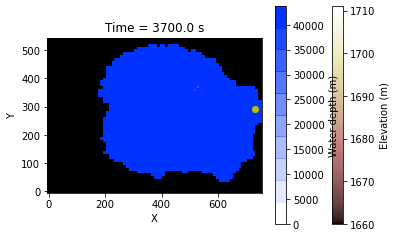

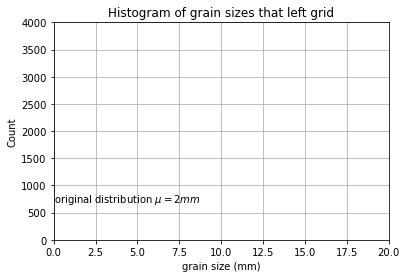

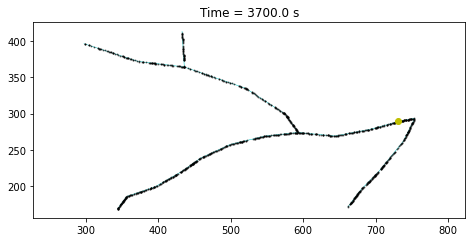

3701.0
3702.0
3703.0
3704.0
3705.0
3706.0
3707.0
3708.0
3709.0
3710.0
3711.0
3712.0
3713.0
3714.0
3715.0
3716.0
3717.0
3718.0
3719.0
3720.0
3721.0
3722.0
3723.0
3724.0
3725.0
3726.0
3727.0
3728.0
3729.0
STORMMMM
3730.0
3731.0
3732.0
3733.0
3734.0
3735.0
3736.0
3737.0
3738.0
3739.0
3740.0
3741.0
3742.0
3743.0
3744.0
3745.0
3746.0
3747.0
3748.0
3749.0
3750.0
STORMMMM
3751.0
3752.0
3753.0
3754.0
3755.0
3756.0
3757.0
3758.0
3759.0
3760.0
3761.0
3762.0
3763.0
3764.0
3765.0
3766.0
3767.0
3768.0
3769.0
3770.0
3771.0
3772.0
3773.0
3774.0
3775.0
3776.0
3777.0
3778.0
3779.0
STORMMMM
3780.0
3781.0
3782.0
3783.0
3784.0
3785.0
3786.0
3787.0
3788.0
3789.0
3790.0
3791.0
3792.0
3793.0
3794.0
3795.0
3796.0
3797.0
3798.0
3799.0
3800.0
STORMMMM
Sed transporter run at model time:  0.04398148148148148 days passed


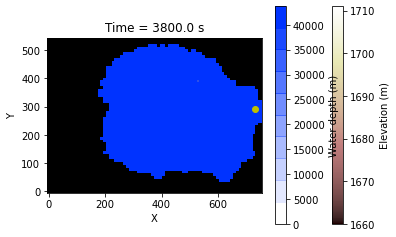

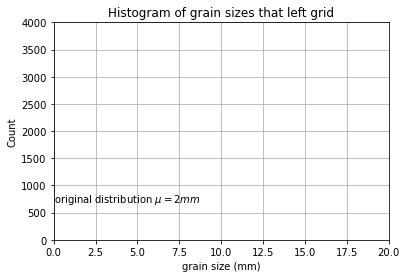

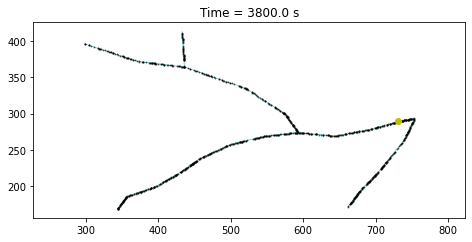

3801.0
3802.0
3803.0
3804.0
3805.0
3806.0
3807.0
3808.0
3809.0
3810.0
3811.0
3812.0
3813.0
3814.0
3815.0
3816.0
3817.0
3818.0
3819.0
3820.0
3821.0
3822.0
3823.0
3824.0
3825.0
3826.0
3827.0
3828.0
3829.0
STORMMMM
3830.0
3831.0
3832.0
3833.0
3834.0
3835.0
3836.0
3837.0
3838.0
3839.0
3840.0
3841.0
3842.0
3843.0
3844.0
3845.0
3846.0
3847.0
3848.0
3849.0
3850.0
STORMMMM
3851.0
3852.0
3853.0
3854.0
3855.0
3856.0
3857.0
3858.0
3859.0
3860.0
3861.0
3862.0
3863.0
3864.0
3865.0
3866.0
3867.0
3868.0
3869.0
3870.0
3871.0
3872.0
3873.0
3874.0
3875.0
3876.0
3877.0
3878.0
3879.0
STORMMMM
3880.0
3881.0
3882.0
3883.0
3884.0
3885.0
3886.0
3887.0
3888.0
3889.0
3890.0
3891.0
3892.0
3893.0
3894.0
3895.0
3896.0
3897.0
3898.0
3899.0
STORMMMM
3900.0
STORMMMM
Sed transporter run at model time:  0.04513888888888889 days passed


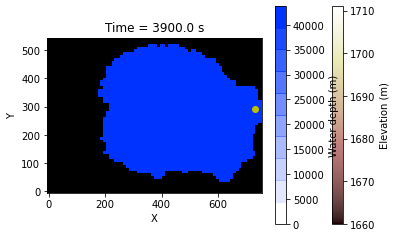

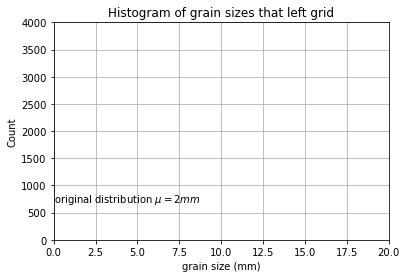

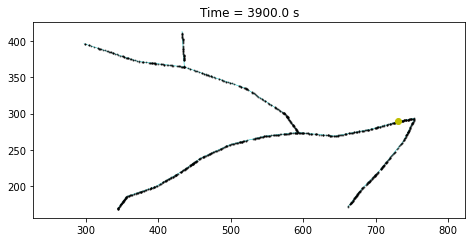

3901.0
3902.0
3903.0
3904.0
3905.0
3906.0
3907.0
3908.0
3909.0
3910.0
3911.0
3912.0
3913.0
3914.0
3915.0
3916.0
3917.0
3918.0
3919.0
3920.0
3921.0
3922.0
3923.0
3924.0
3925.0
3926.0
3927.0
3928.0
3929.0
STORMMMM
3930.0
3931.0
3932.0
3933.0
3934.0
3935.0
3936.0
3937.0
3938.0
3939.0
3940.0
3941.0
3942.0
3943.0
3944.0
3945.0
3946.0
3947.0
3948.0
3949.0
3950.0
STORMMMM
3951.0
3952.0
3953.0
3954.0
3955.0
3956.0
3957.0
3958.0
3959.0
3960.0
3961.0
3962.0
3963.0
3964.0
3965.0
3966.0
3967.0
3968.0
3969.0
3970.0
3971.0
3972.0
3973.0
3974.0
3975.0
3976.0
3977.0
3978.0
3979.0
STORMMMM
3980.0
3981.0
3982.0
3983.0
3984.0
3985.0
3986.0
3987.0
3988.0
3989.0
3990.0
3991.0
3992.0
3993.0
3994.0
3995.0
3996.0
3997.0
3998.0
3999.0
4000.0
STORMMMM
Sed transporter run at model time:  0.046296296296296294 days passed


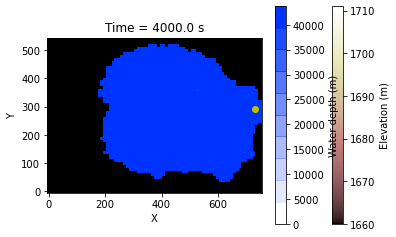

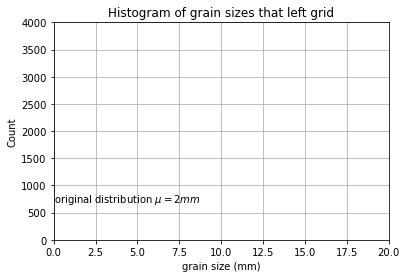

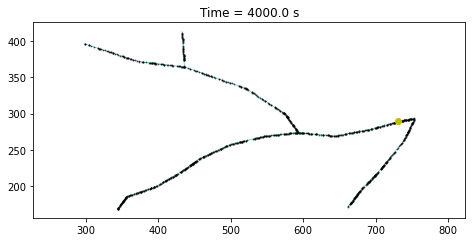

4001.0
4002.0
4003.0
4004.0
4005.0
4006.0
4007.0
4008.0
4009.0
4010.0
4011.0
4012.0
4013.0
4014.0
4015.0
4016.0
4017.0
4018.0
4019.0
4020.0
4021.0
4022.0
4023.0
4024.0
4025.0
4026.0
4027.0
4028.0
4029.0
STORMMMM
4030.0
4031.0
4032.0
4033.0
4034.0
4035.0
4036.0
4037.0
4038.0
4039.0
4040.0
4041.0
4042.0
4043.0
4044.0
4045.0
4046.0
4047.0
4048.0
4049.0
4050.0
STORMMMM
4051.0
4052.0
4053.0
4054.0
4055.0
4056.0
4057.0
4058.0
4059.0
4060.0
4061.0
4062.0
4063.0
4064.0
4065.0
4066.0
4067.0
4068.0
4069.0
4070.0
4071.0
4072.0
4073.0
4074.0
4075.0
4076.0
4077.0
4078.0
4079.0
STORMMMM
4080.0
4081.0
4082.0
4083.0
4084.0
4085.0
4086.0
4087.0
4088.0
4089.0
4090.0
4091.0
4092.0
4093.0
4094.0
4095.0
4096.0
4097.0
4098.0
4099.0
4100.0
STORMMMM
Sed transporter run at model time:  0.047453703703703706 days passed


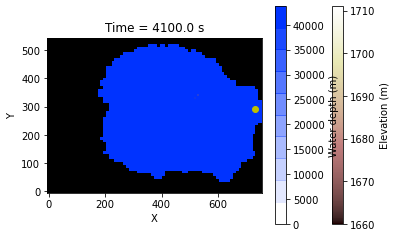

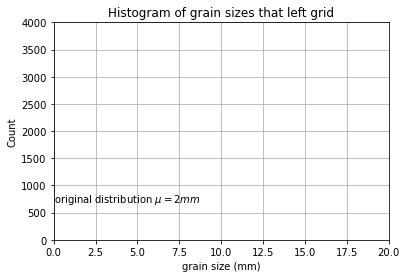

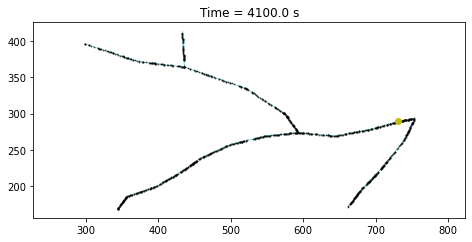

4101.0
4102.0
4103.0
4104.0
4105.0
4106.0
4107.0
4108.0
4109.0
4110.0
4111.0
4112.0
4113.0
4114.0
4115.0
4116.0
4117.0
4118.0
4119.0
4120.0
4121.0
4122.0
4123.0
4124.0
4125.0
4126.0
4127.0
4128.0
4129.0
STORMMMM
4130.0
4131.0
4132.0
4133.0
4134.0
4135.0
4136.0
4137.0
4138.0
4139.0
4140.0
4141.0
4142.0
4143.0
4144.0
4145.0
4146.0
4147.0
4148.0
4149.0
4150.0
STORMMMM
4151.0
4152.0
4153.0
4154.0
4155.0
4156.0
4157.0
4158.0
4159.0
4160.0
4161.0
4162.0
4163.0
4164.0
4165.0
4166.0
4167.0
4168.0
4169.0
4170.0
4171.0
4172.0
4173.0
4174.0
4175.0
4176.0
4177.0
4178.0
4179.0
STORMMMM
4180.0
4181.0
4182.0
4183.0
4184.0
4185.0
4186.0
4187.0
4188.0
4189.0
4190.0
4191.0
4192.0
4193.0
4194.0
4195.0
4196.0
4197.0
4198.0
4199.0
4200.0
STORMMMM
Sed transporter run at model time:  0.04861111111111111 days passed


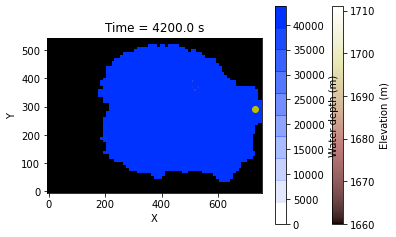

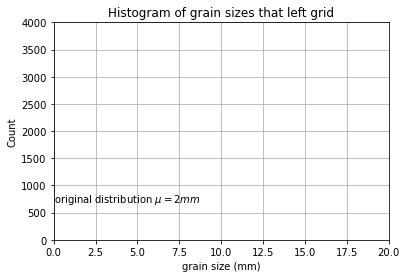

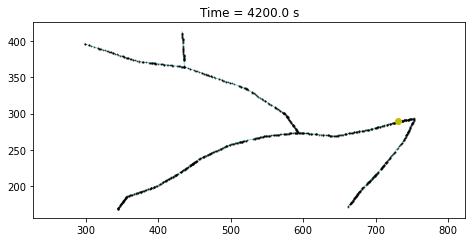

4201.0
4202.0
4203.0
4204.0
4205.0
4206.0
4207.0
4208.0
4209.0
4210.0
4211.0
4212.0
4213.0
4214.0
4215.0
4216.0
4217.0
4218.0
4219.0
4220.0
4221.0
4222.0
4223.0
4224.0
4225.0
4226.0
4227.0
4228.0
4229.0
STORMMMM
4230.0
4231.0
4232.0
4233.0
4234.0
4235.0
4236.0
4237.0
4238.0
4239.0
4240.0
4241.0
4242.0
4243.0
4244.0
4245.0
4246.0
4247.0
4248.0
4249.0
4250.0
STORMMMM
4251.0
4252.0
4253.0
4254.0
4255.0
4256.0
4257.0
4258.0
4259.0
4260.0
4261.0
4262.0
4263.0
4264.0
4265.0
4266.0
4267.0
4268.0
4269.0
4270.0
4271.0
4272.0
4273.0
4274.0
4275.0
4276.0
4277.0
4278.0
4279.0
STORMMMM
4280.0
4281.0
4282.0
4283.0
4284.0
4285.0
4286.0
4287.0
4288.0
4289.0
4290.0
4291.0
4292.0
4293.0
4294.0
4295.0
4296.0
4297.0
4298.0
4299.0
4300.0
STORMMMM
Sed transporter run at model time:  0.04976851851851852 days passed


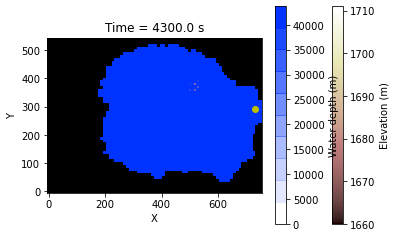

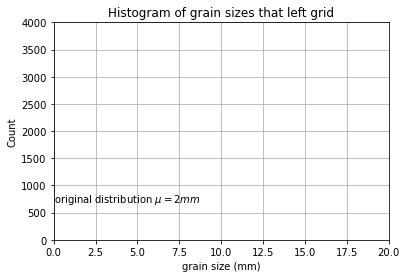

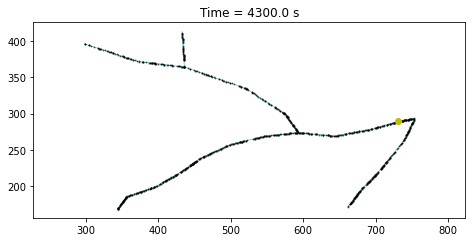

4301.0
4302.0
4303.0
4304.0
4305.0
4306.0
4307.0
4308.0
4309.0
4310.0
4311.0
4312.0
4313.0
4314.0
4315.0
4316.0
4317.0
4318.0
4319.0
4320.0
4321.0
4322.0
4323.0
4324.0
4325.0
4326.0
4327.0
4328.0
4329.0
STORMMMM
4330.0
4331.0
4332.0
4333.0
4334.0
4335.0
4336.0
4337.0
4338.0
4339.0
4340.0
4341.0
4342.0
4343.0
4344.0
4345.0
4346.0
4347.0
4348.0
4349.0
4350.0
STORMMMM
4351.0
4352.0
4353.0
4354.0
4355.0
4356.0
4357.0
4358.0
4359.0
4360.0
4361.0
4362.0
4363.0
4364.0
4365.0
4366.0
4367.0
4368.0
4369.0
4370.0
4371.0
4372.0
4373.0
4374.0
4375.0
4376.0
4377.0
4378.0
4379.0
STORMMMM
4380.0
4381.0
4382.0
4383.0
4384.0
4385.0
4386.0
4387.0
4388.0
4389.0
4390.0
4391.0
4392.0
4393.0
4394.0
4395.0
4396.0
4397.0
4398.0
4399.0
4400.0
STORMMMM
Sed transporter run at model time:  0.05092592592592592 days passed


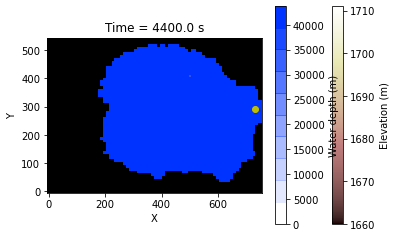

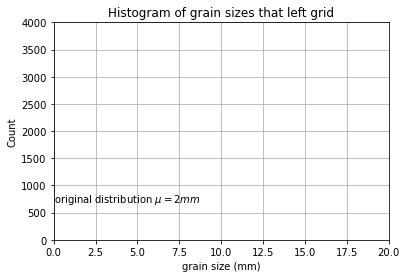

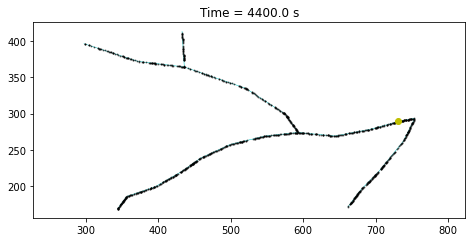

4401.0
4402.0
4403.0
4404.0
4405.0
4406.0
4407.0
4408.0
4409.0
4410.0
4411.0
4412.0
4413.0
4414.0
4415.0
4416.0
4417.0
4418.0
4419.0
4420.0
4421.0
4422.0
4423.0
4424.0
4425.0
4426.0
4427.0
4428.0
4429.0
STORMMMM
4430.0
4431.0
4432.0
4433.0
4434.0
4435.0
4436.0
4437.0
4438.0
4439.0
4440.0
4441.0
4442.0
4443.0
4444.0
4445.0
4446.0
4447.0
4448.0
4449.0
4450.0
STORMMMM
4451.0
4452.0
4453.0
4454.0
4455.0
4456.0
4457.0
4458.0
4459.0
4460.0
4461.0
4462.0
4463.0
4464.0
4465.0
4466.0
4467.0
4468.0
4469.0
4470.0
4471.0
4472.0
4473.0
4474.0
4475.0
4476.0
4477.0
4478.0
4479.0
STORMMMM
4480.0
4481.0
4482.0
4483.0
4484.0
4485.0
4486.0
4487.0
4488.0
4489.0
4490.0
4491.0
4492.0
4493.0
4494.0
4495.0
4496.0
4497.0
4498.0
4499.0
4500.0
STORMMMM
Sed transporter run at model time:  0.052083333333333336 days passed


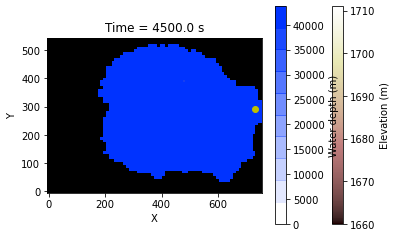

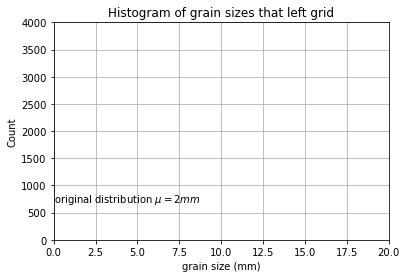

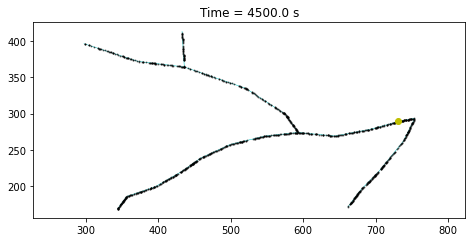

4501.0
4502.0
4503.0
4504.0
4505.0
4506.0
4507.0
4508.0
4509.0
4510.0
4511.0
4512.0
4513.0
4514.0
4515.0
4516.0
4517.0
4518.0
4519.0
4520.0
4521.0
4522.0
4523.0
4524.0
4525.0
4526.0
4527.0
4528.0
4529.0
STORMMMM
4530.0
4531.0
4532.0
4533.0
4534.0
4535.0
4536.0
4537.0
4538.0
4539.0
4540.0
4541.0
4542.0
4543.0
4544.0
4545.0
4546.0
4547.0
4548.0
4549.0
4550.0
STORMMMM
4551.0
4552.0
4553.0
4554.0
4555.0
4556.0
4557.0
4558.0
4559.0
4560.0
4561.0
4562.0
4563.0
4564.0
4565.0
4566.0
4567.0
4568.0
4569.0
4570.0
4571.0
4572.0
4573.0
4574.0
4575.0
4576.0
4577.0
4578.0
4579.0
STORMMMM
4580.0
4581.0
4582.0
4583.0
4584.0
4585.0
4586.0
4587.0
4588.0
4589.0
4590.0
4591.0
4592.0
4593.0
4594.0
4595.0
4596.0
4597.0
4598.0
4599.0
4600.0
STORMMMM
Sed transporter run at model time:  0.05324074074074074 days passed


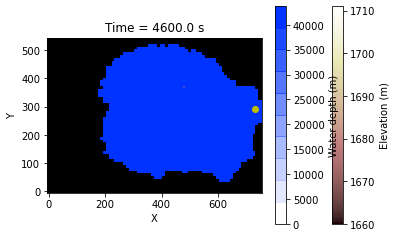

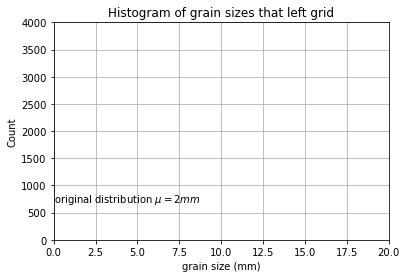

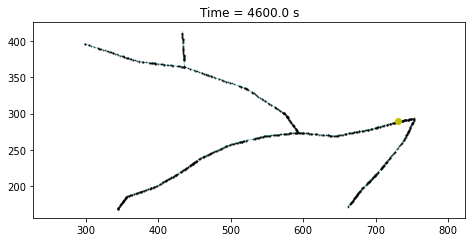

4601.0
4602.0
4603.0
4604.0
4605.0
4606.0
4607.0
4608.0
4609.0
4610.0
4611.0
4612.0
4613.0
4614.0
4615.0
4616.0
4617.0
4618.0
4619.0
4620.0
4621.0
4622.0
4623.0
4624.0
4625.0
4626.0
4627.0
4628.0
4629.0
STORMMMM
4630.0
4631.0
4632.0
4633.0
4634.0
4635.0
4636.0
4637.0
4638.0
4639.0
4640.0
4641.0
4642.0
4643.0
4644.0
4645.0
4646.0
4647.0
4648.0
4649.0
4650.0
STORMMMM
4651.0
4652.0
4653.0
4654.0
4655.0
4656.0
4657.0
4658.0
4659.0
4660.0
4661.0
4662.0
4663.0
4664.0
4665.0
4666.0
4667.0
4668.0
4669.0
4670.0
4671.0
4672.0
4673.0
4674.0
4675.0
4676.0
4677.0
4678.0
4679.0
STORMMMM
4680.0
4681.0
4682.0
4683.0
4684.0
4685.0
4686.0
4687.0
4688.0
4689.0
4690.0
4691.0
4692.0
4693.0
4694.0
4695.0
4696.0
4697.0
4698.0
4699.0
4700.0
STORMMMM
Sed transporter run at model time:  0.05439814814814815 days passed


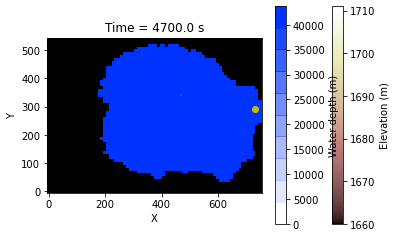

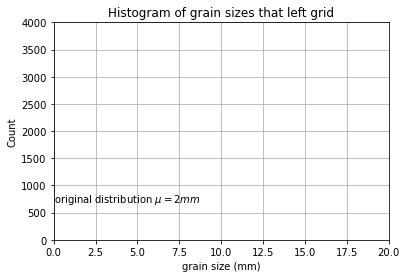

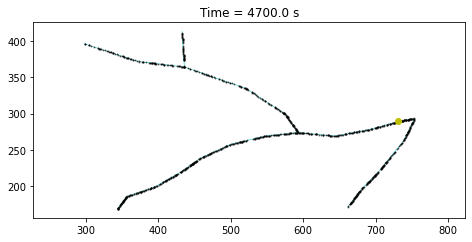

4701.0
4702.0
4703.0
4704.0
4705.0
4706.0
4707.0
4708.0
4709.0
4710.0
4711.0
4712.0
4713.0
4714.0
4715.0
4716.0
4717.0
4718.0
4719.0
4720.0
4721.0
4722.0
4723.0
4724.0
4725.0
4726.0
4727.0
4728.0
4729.0
STORMMMM
4730.0
4731.0
4732.0
4733.0
4734.0
4735.0
4736.0
4737.0
4738.0
4739.0
4740.0
4741.0
4742.0
4743.0
4744.0
4745.0
4746.0
4747.0
4748.0
4749.0
4750.0
STORMMMM
4751.0
4752.0
4753.0
4754.0
4755.0
4756.0
4757.0
4758.0
4759.0
4760.0
4761.0
4762.0
4763.0
4764.0
4765.0
4766.0
4767.0
4768.0
4769.0
4770.0
4771.0
4772.0
4773.0
4774.0
4775.0
4776.0
4777.0
4778.0
4779.0
STORMMMM
4780.0
4781.0
4782.0
4783.0
4784.0
4785.0
4786.0
4787.0
4788.0
4789.0
4790.0
4791.0
4792.0
4793.0
4794.0
4795.0
4796.0
4797.0
4798.0
4799.0
4800.0
STORMMMM
Sed transporter run at model time:  0.05555555555555555 days passed


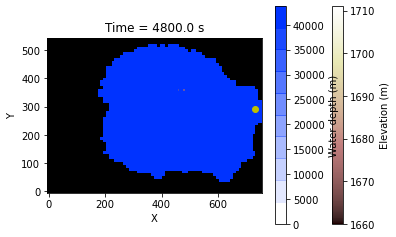

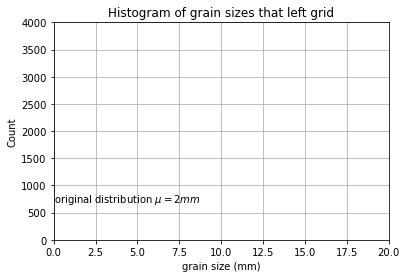

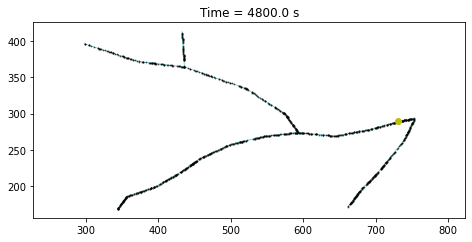

4801.0
4802.0
4803.0
4804.0
4805.0
4806.0
4807.0
4808.0
4809.0
4810.0
4811.0
4812.0
4813.0
4814.0
4815.0
4816.0
4817.0
4818.0
4819.0
4820.0
4821.0
4822.0
4823.0
4824.0
4825.0
4826.0
4827.0
4828.0
4829.0
STORMMMM
4830.0
4831.0
4832.0
4833.0
4834.0
4835.0
4836.0
4837.0
4838.0
4839.0
4840.0
4841.0
4842.0
4843.0
4844.0
4845.0
4846.0
4847.0
4848.0
4849.0
4850.0
STORMMMM
4851.0
4852.0
4853.0
4854.0
4855.0
4856.0
4857.0
4858.0
4859.0
4860.0
4861.0
4862.0
4863.0
4864.0
4865.0
4866.0
4867.0
4868.0
4869.0
4870.0
4871.0
4872.0
4873.0
4874.0
4875.0
4876.0
4877.0
4878.0
4879.0
STORMMMM
4880.0
4881.0
4882.0
4883.0
4884.0
4885.0
4886.0
4887.0
4888.0
4889.0
4890.0
4891.0
4892.0
4893.0
4894.0
4895.0
4896.0
4897.0
4898.0
4899.0
4900.0
STORMMMM
Sed transporter run at model time:  0.056712962962962965 days passed


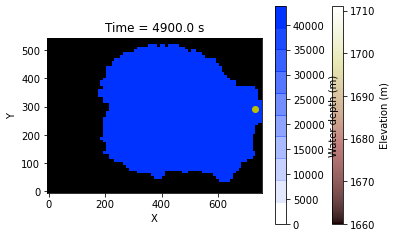

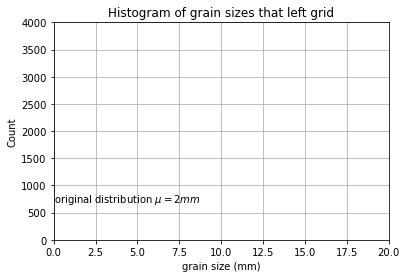

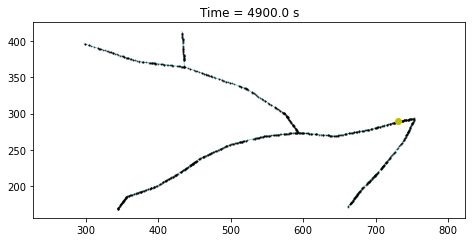

4901.0
4902.0
4903.0
4904.0
4905.0
4906.0
4907.0
4908.0
4909.0
4910.0
4911.0
4912.0
4913.0
4914.0
4915.0
4916.0
4917.0
4918.0
4919.0
4920.0
4921.0
4922.0
4923.0
4924.0
4925.0
4926.0
4927.0
4928.0
4929.0
STORMMMM
4930.0
4931.0
4932.0
4933.0
4934.0
4935.0
4936.0
4937.0
4938.0
4939.0
4940.0
4941.0
4942.0
4943.0
4944.0
4945.0
4946.0
4947.0
4948.0
4949.0
4950.0
STORMMMM
4951.0
4952.0
4953.0
4954.0
4955.0
4956.0
4957.0
4958.0
4959.0
4960.0
4961.0
4962.0
4963.0
4964.0
4965.0
4966.0
4967.0
4968.0
4969.0
4970.0
4971.0
4972.0
4973.0
4974.0
4975.0
4976.0
4977.0
4978.0
4979.0
STORMMMM
4980.0
4981.0
4982.0
4983.0
4984.0
4985.0
4986.0
4987.0
4988.0
4989.0
4990.0
4991.0
4992.0
4993.0
4994.0
4995.0
4996.0
4997.0
4998.0
4999.0
5000.0
Sed transporter run at model time:  0.05787037037037037 days passed


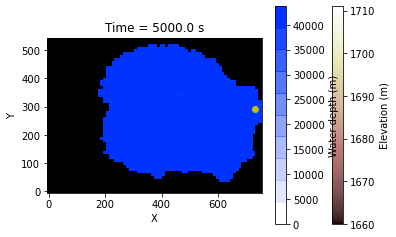

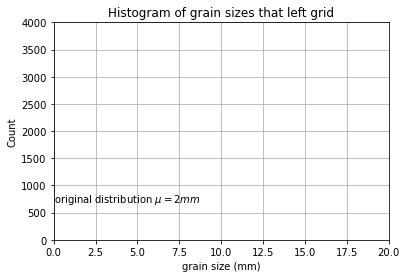

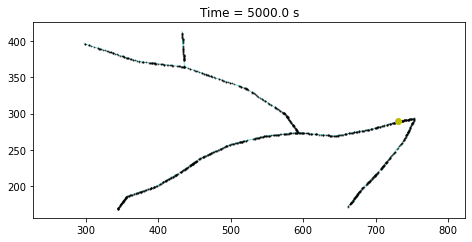

In [529]:
# this section can take selveral minutes to run

elapsed_time = 1.
run_time_slices = np.arange(dt_sed,run_time+1,dt_sed) #every sed transport timestep
  
#Run model
for t in run_time_slices:
    #Run overland until next time to run sed transport
    while elapsed_time < t: 
        # First, we calculate our time step.
        # dt_overland = of.calc_time_step()
        dt_overland = 1
        # print('overland flow timestep is',dt_overland,'seconds')
        # Now, we can generate overland flow.
        of.overland_flow()
        # Increased elapsed time
        elapsed_time += dt_overland
        #print("Model time: ",elapsed_time/(60*60*24), "days passed")
        ## Append time and discharge and water depth to their lists to save data and for plotting.
        hydrograph_time.append(elapsed_time) 
        q = rmg.at_link["surface_water__discharge"]
        discharge_at_outlet.append(np.abs(q[outlet_link_to_sample]) * rmg.dx)
        h = rmg.at_node['surface_water__depth']
        height_at_outlet.append(np.abs(h[outlet_nearest_raster_cell]))
        
        # print(elapsed_time)
        # ---------------------------------------------------------------

        if elapsed_time in scaled_days_storms:
            # print("STORMMMM")
            # Update rainfall dataset id
            rainfall_id += 1
            rainfall_name = 'rainfall__flux_' + str(rainfall_id)
            # print(rainfall_id)

            # Avoid last time step
            if rainfall_id <= len(scaled_days_storms):
                # Read rainfall data
                # rmg.at_node.pop('rainfall__flux')
                q_rain = read_esri_ascii('./rainfall_series/rainfall_' + str(rainfall_id) + '.asc', grid=rmg, name=rainfall_name)
                # Add rainfall event to water depth
                rmg.at_node['surface_water__depth'] += rmg.at_node[rainfall_name]

        # ---------------------------------------------------------------
    
    # updated the water depth in network graph
    for i in range(new_grid.number_of_links):
        idx_node_2_link = new_grid.nodes_at_link[i][1]
        nmg_link_h[i] = rmg.at_node['surface_water__depth'][idx_node_2_link] #assume second node is downstream one
    new_grid.at_link["flow_depth"] = nmg_link_h.copy()
    
#     # Make more rain 
#     # h[bools]=1#water depth m
#     rmg.at_node['surface_water__depth'] += 100
    
    #Run sed transport 
    nst.run_one_step(dt_sed)
    print("Sed transporter run at model time: ",elapsed_time/(60*60*24), "days passed")
    
    #Plot overland flow 
    fig=plt.figure()
    imshow_grid(rmg,'topographic__elevation',colorbar_label='Elevation (m)')
    imshow_grid(rmg,'surface_water__depth',limits=(0,np.array(max_rainfall).max()),cmap=cmap,colorbar_label='Water depth (m)')
    plt.title(f'Time = {round(elapsed_time,1)} s')
    plt.plot(rmg.node_x[outlet_nearest_raster_cell], rmg.node_y[outlet_nearest_raster_cell], "yo")
    plt.show()
    fig.savefig(f"Hima_results/runoff_{round(elapsed_time,1)}.jpeg")
    
    #grain size
    parcel_D = parcels.dataset.D.values.copy()
    parcel_D_off_grid=parcel_D[parcels.dataset["element_id"].values==-2] 

    # the histogram of the data
    plt.hist(parcel_D_off_grid*1000, histtype='bar')

    plt.xlabel('grain size (mm)')
    plt.ylabel('Count')
    plt.title('Histogram of grain sizes that left grid')
    plt.text(0.011, 700, r'original distribution $\mu=2 mm$')
    plt.xlim(0, 20)
    plt.ylim(0, 4000)
    plt.grid(True)
    plt.show()

    #Plot sediment parcels locations
    fig = plot_network_and_parcels(
            grid, parcels, 
            parcel_time_index=len(parcels.time_coordinates)-1)
    plt.plot(rmg.node_x[outlet_nearest_raster_cell], rmg.node_y[outlet_nearest_raster_cell], "yo")
    plt.title(f'Time = {round(elapsed_time,1)} s')
    plt.show()
    fig.savefig(f"Hima_results/sedparcels_{round(elapsed_time,1)}.jpeg")

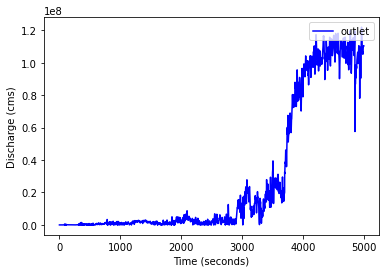

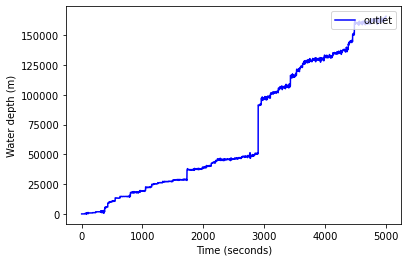

In [530]:
## Plotting hydrographs and discharge
fig=plt.figure(2)
plt.plot(hydrograph_time, discharge_at_outlet, "b-", label="outlet")

plt.ylabel("Discharge (cms)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
fig.savefig(dir_runoff + f"/runoff_discharge.jpeg")

fig=plt.figure(3)
plt.plot(hydrograph_time, height_at_outlet, "b-", label="outlet")
plt.ylabel("Water depth (m)")
plt.xlabel("Time (seconds)")
plt.legend(loc="upper right")
fig.savefig(dir_runoff + f"/runoff_waterdepth.jpeg")

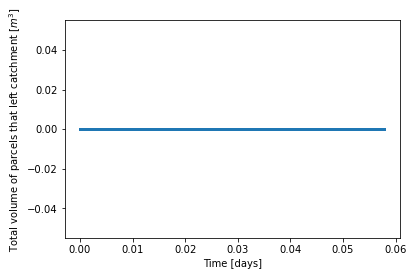

In [531]:
## Plotting sediment volume
parcel_vol_on_grid = parcels.dataset["volume"].values
parcel_vol_on_grid[parcels.dataset["element_id"].values==-2]=0

sum_parcel_vol_on_grid = np.sum(parcel_vol_on_grid, axis=0)

#plt.figure(figsize=(8,6))
plt.plot(np.asarray(parcels.time_coordinates)/(60*60*24), 
         sum_parcel_vol_on_grid[0]-sum_parcel_vol_on_grid,
         '-',
         linewidth=3, 
        )
plt.ylabel('Total volume of parcels that left catchment $[m^3]$')
plt.xlabel('Time [days]')
plt.show() 

In [532]:
plt.plot(test)
plt.show()

NameError: name 'test' is not defined